Notre projet vise à étudier un jeu de données contenant des informations démographiques et historiques des prisonniers incarcérés pendant la période de la prohibition afin de prédire la probabilité de récidive. Nous allons utiliser plusieurs algorithmes de machine learning pour analyser et comparer leurs performances sur notre jeu de données.

# Les librairies utilisées 

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import warnings
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.cluster import KMeans


# Chargement de la dataset

In [2]:
df = pd.read_csv('Recidivism_Dataset.csv')
df.head()

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
0,1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,...,0.000000,0.0,0.488562,0.447610,False,False,False,False,False,1
1,2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,0.000000,0.0,0.425234,2.000000,False,True,False,False,True,1
2,3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,...,0.166667,0.0,0.000000,0.000000,False,True,False,True,False,1
3,4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,...,0.000000,0.0,1.000000,0.718996,False,False,False,False,False,1
4,5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,...,0.058824,0.0,0.203562,0.929389,False,True,True,False,False,1


In [3]:
df.shape

(25835, 54)

In [4]:
df.drop(columns=['ID', 'Training_Sample', 'Recidivism_Arrest_Year3', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year1'], inplace=True)

# !PRE-TRAITEMENT DU JEU DE DONNEES

# I - Data cleaning 

# 1) Les valeurs manquantes

In [5]:
missing_values = df.isnull().sum()
print(missing_values)

Gender                                                  0
Race                                                    0
Age_at_Release                                          0
Residence_PUMA                                          0
Gang_Affiliated                                      3167
Supervision_Risk_Score_First                          475
Supervision_Level_First                              1720
Education_Level                                         0
Dependents                                              0
Prison_Offense                                       3277
Prison_Years                                            0
Prior_Arrest_Episodes_Felony                            0
Prior_Arrest_Episodes_Misd                              0
Prior_Arrest_Episodes_Violent                           0
Prior_Arrest_Episodes_Property                          0
Prior_Arrest_Episodes_Drug                              0
Prior_Arrest_Episodes_PPViolationCharges                0
Prior_Arrest_E

In [6]:
df.drop(columns=['DrugTests_THC_Positive', 'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 'Avg_Days_per_DrugTest'], inplace=True)

On a supprime les colonnes qui presentes beaucoup de valeurs manquantes 

In [7]:
imputer = SimpleImputer(strategy='median')
df['Supervision_Risk_Score_First'] = imputer.fit_transform(df[['Supervision_Risk_Score_First']])

df['Gang_Affiliated'] = df['Gang_Affiliated'].astype(float)
mode_imputer = SimpleImputer(strategy='most_frequent')
df['Gang_Affiliated'] = mode_imputer.fit_transform(df['Gang_Affiliated'].values.reshape(-1, 1))

mode_value_prison = df['Prison_Offense'].mode()[0]
df['Prison_Offense'] = df['Prison_Offense'].fillna(mode_value_prison)

mode_value_supervision = df['Supervision_Level_First'].mode()[0]
df['Supervision_Level_First'] = df['Supervision_Level_First'].fillna(mode_value_supervision)

mode_value_prison = df['Percent_Days_Employed'].mode()[0]
df['Percent_Days_Employed'] = df['Percent_Days_Employed'].fillna(mode_value_prison)

mode_value_prison = df['Jobs_Per_Year'].mode()[0]
df['Jobs_Per_Year'] = df['Jobs_Per_Year'].fillna(mode_value_prison)

Pour les autres valeurs manquantes , on a utilier differentes methodes pour les remplir : median , la valeur la plus frequente et le mode

In [8]:
missing_values = df.isnull().sum()
print(missing_values)

Gender                                               0
Race                                                 0
Age_at_Release                                       0
Residence_PUMA                                       0
Gang_Affiliated                                      0
Supervision_Risk_Score_First                         0
Supervision_Level_First                              0
Education_Level                                      0
Dependents                                           0
Prison_Offense                                       0
Prison_Years                                         0
Prior_Arrest_Episodes_Felony                         0
Prior_Arrest_Episodes_Misd                           0
Prior_Arrest_Episodes_Violent                        0
Prior_Arrest_Episodes_Property                       0
Prior_Arrest_Episodes_Drug                           0
Prior_Arrest_Episodes_PPViolationCharges             0
Prior_Arrest_Episodes_DVCharges                      0
Prior_Arre

# 2) Les outliers

In [9]:
# Find the columns recognized as logical
logical_cols = df.select_dtypes(include='bool').columns
print(logical_cols)

# Convert them to numeric 0s and 1s
df[logical_cols] = df[logical_cols].astype(int)

Index(['Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Viol',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
       'Condition_Other', 'Violations_ElectronicMonitoring',
       'Violations_Instruction', 'Violations_FailToReport',
       'Violations_MoveWithoutPermission', 'Employment_Exempt',
       'Recidivism_Within_3years'],
      dtype='object')


In [10]:
# Mapping dictionaries
dependents_map = {'0': 0, '1': 1, '2': 2, '3 or more': 3}
prior_arrest_episodes_felony_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10 or more': 10}
prior_arrest_episodes_misd_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6 or more': 6}
prior_arrest_episodes_violent_map = {'0': 0, '1': 1, '2': 2, '3 or more': 3}
prior_arrest_episodes_property_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5 or more': 5}
prior_arrest_episodes_drug_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5 or more': 5}
prior_arrest_episodes_ppviolationcharges_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5 or more': 5}
prior_conviction_episodes_felony_map = {'0': 0, '1': 1, '2': 2, '3 or more': 3}
prior_conviction_episodes_misd_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4 or more': 4}
prior_conviction_episodes_prop_map = {'0': 0, '1': 1, '2': 2, '3 or more': 3}
prior_conviction_episodes_drug_map = {'0': 0, '1': 1, '2 or more': 2}
delinquency_reports_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4 or more': 4}
program_attendances_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10 or more': 10}
program_unexcused_absences_map = {'0': 0, '1': 1, '2': 2, '3 or more': 3}
residence_changes_map = {'0': 0, '1': 1, '2': 2, '3 or more': 3}

# Applying mapping to each column
df['Dependents'] = df['Dependents'].map(dependents_map)
df['Prior_Arrest_Episodes_Felony'] = df['Prior_Arrest_Episodes_Felony'].map(prior_arrest_episodes_felony_map)
df['Prior_Arrest_Episodes_Misd'] = df['Prior_Arrest_Episodes_Misd'].map(prior_arrest_episodes_misd_map)
df['Prior_Arrest_Episodes_Violent'] = df['Prior_Arrest_Episodes_Violent'].map(prior_arrest_episodes_violent_map)
df['Prior_Arrest_Episodes_Property'] = df['Prior_Arrest_Episodes_Property'].map(prior_arrest_episodes_property_map)
df['Prior_Arrest_Episodes_Drug'] = df['Prior_Arrest_Episodes_Drug'].map(prior_arrest_episodes_drug_map)
df['Prior_Arrest_Episodes_PPViolationCharges'] = df['Prior_Arrest_Episodes_PPViolationCharges'].map(prior_arrest_episodes_ppviolationcharges_map)
df['Prior_Conviction_Episodes_Felony'] = df['Prior_Conviction_Episodes_Felony'].map(prior_conviction_episodes_felony_map)
df['Prior_Conviction_Episodes_Misd'] = df['Prior_Conviction_Episodes_Misd'].map(prior_conviction_episodes_misd_map)
df['Prior_Conviction_Episodes_Prop'] = df['Prior_Conviction_Episodes_Prop'].map(prior_conviction_episodes_prop_map)
df['Prior_Conviction_Episodes_Drug'] = df['Prior_Conviction_Episodes_Drug'].map(prior_conviction_episodes_drug_map)
df['Delinquency_Reports'] = df['Delinquency_Reports'].map(delinquency_reports_map)
df['Program_Attendances'] = df['Program_Attendances'].map(program_attendances_map)
df['Program_UnexcusedAbsences'] = df['Program_UnexcusedAbsences'].map(program_unexcused_absences_map)
df['Residence_Changes'] = df['Residence_Changes'].map(residence_changes_map)

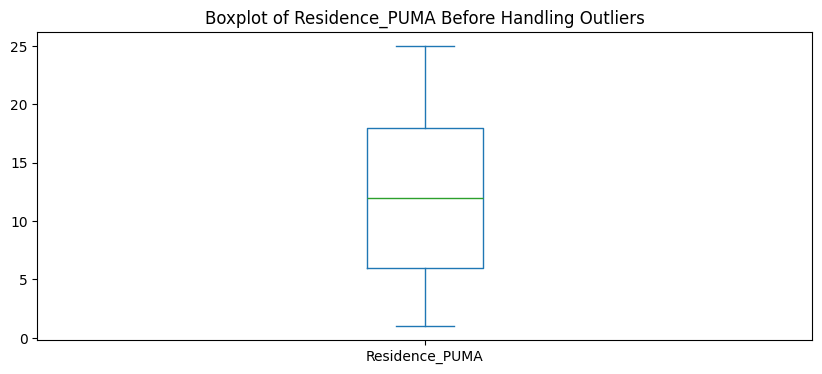

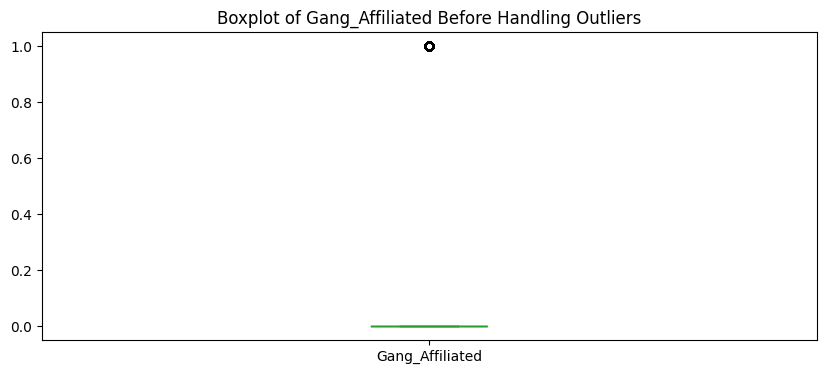

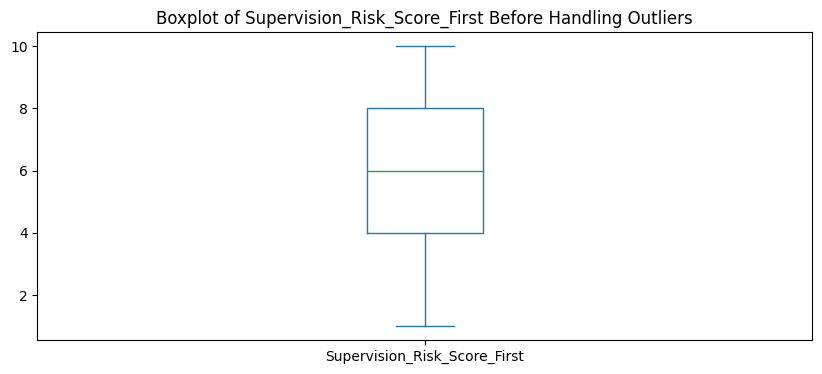

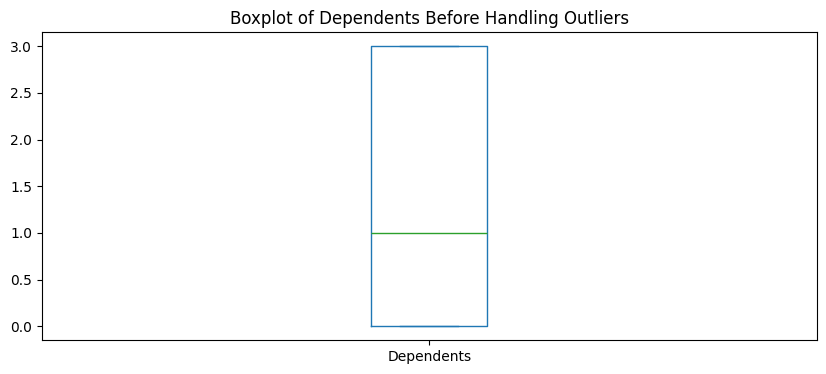

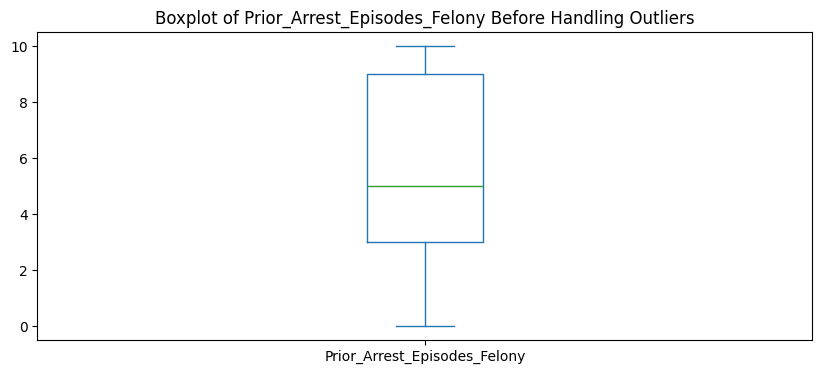

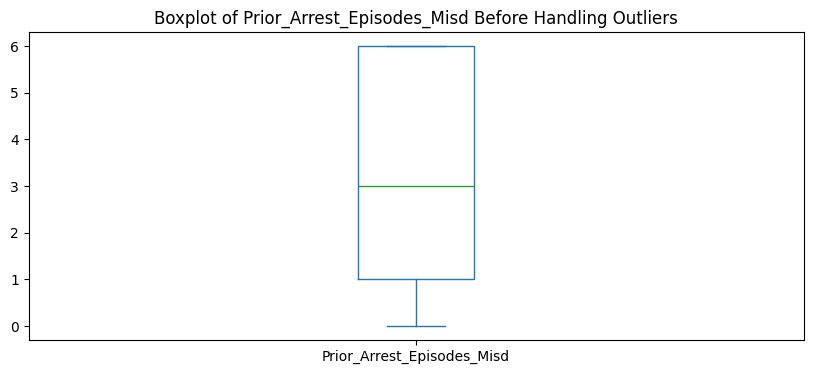

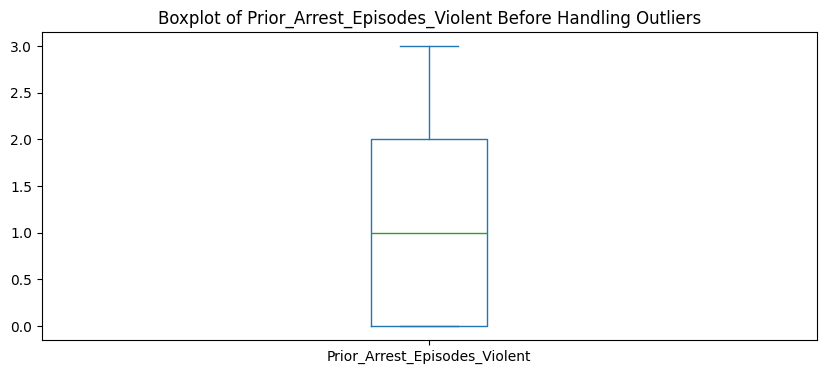

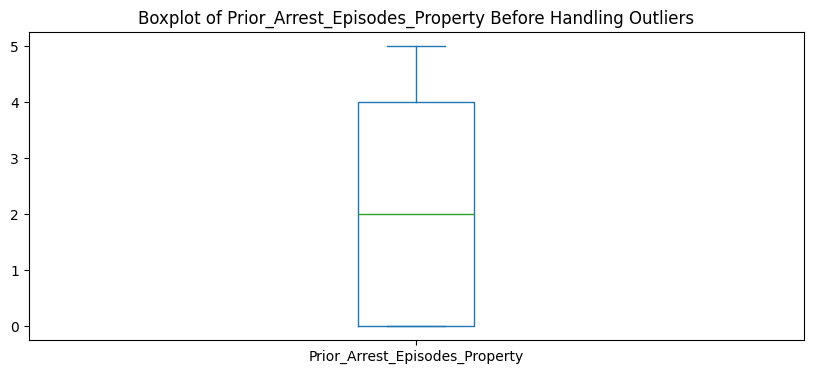

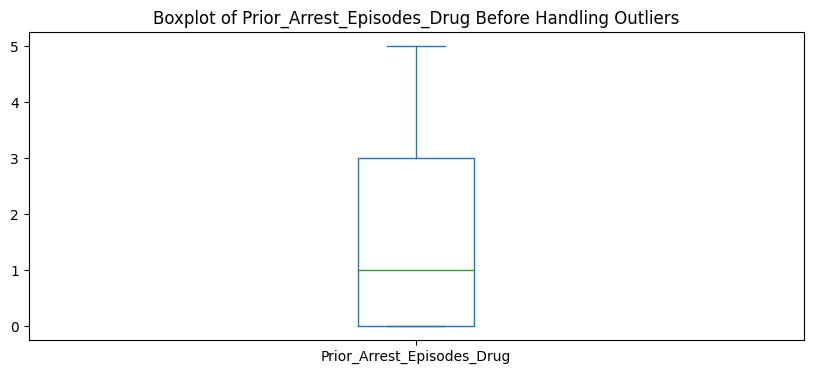

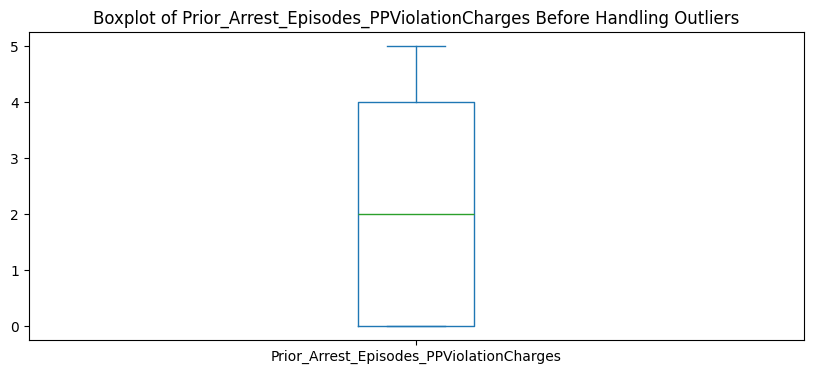

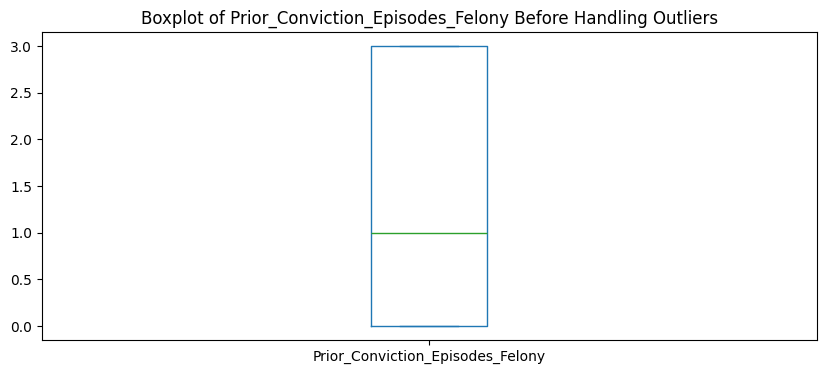

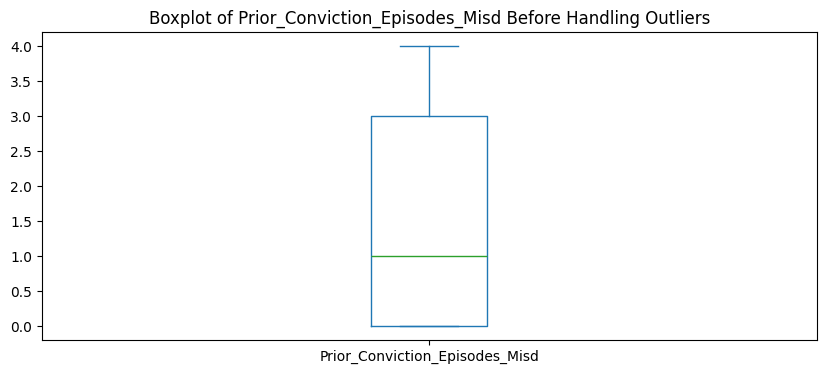

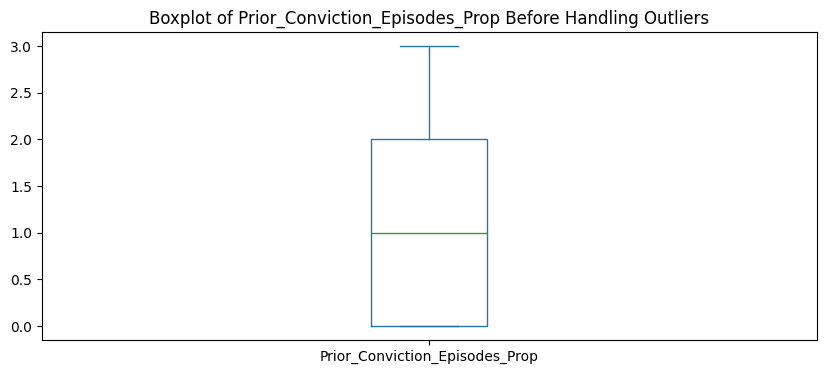

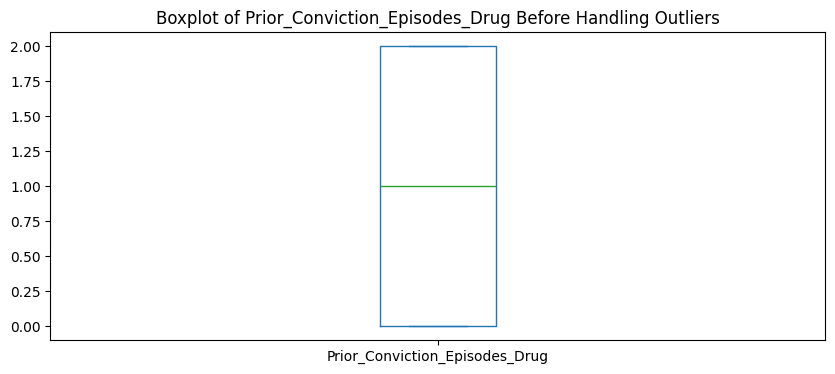

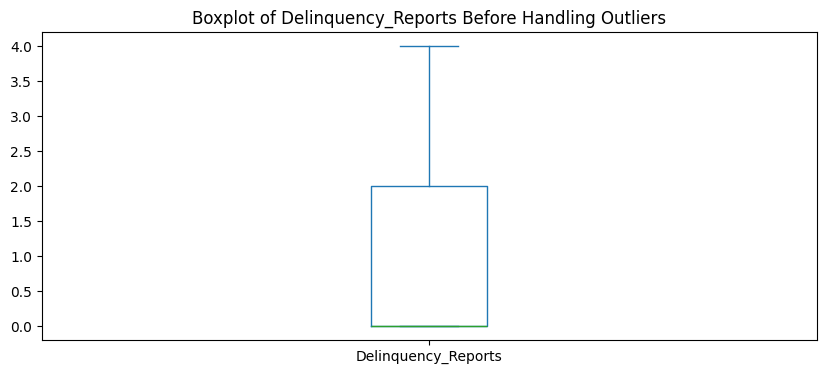

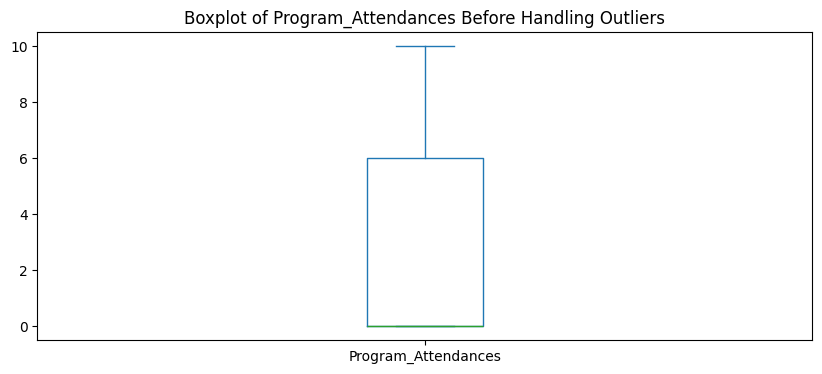

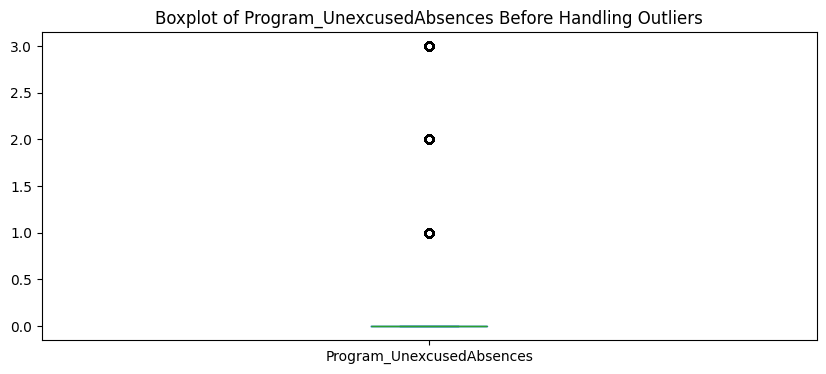

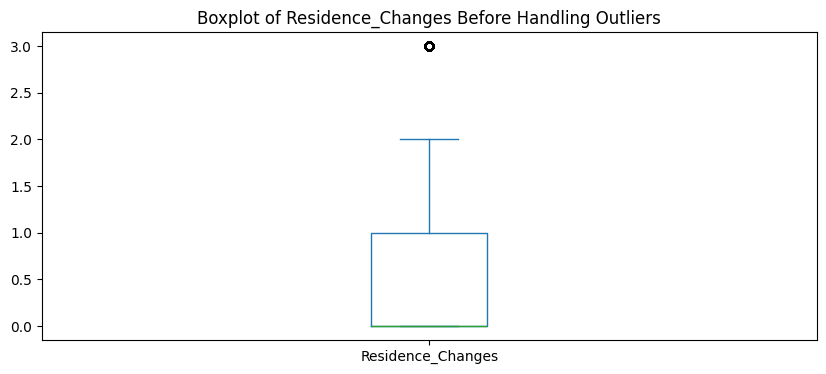

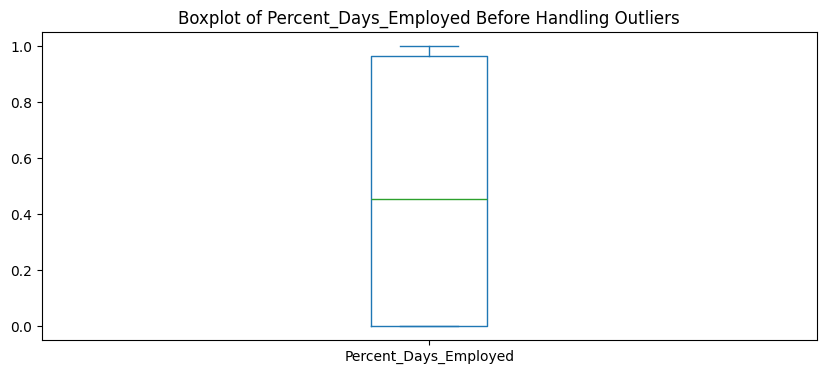

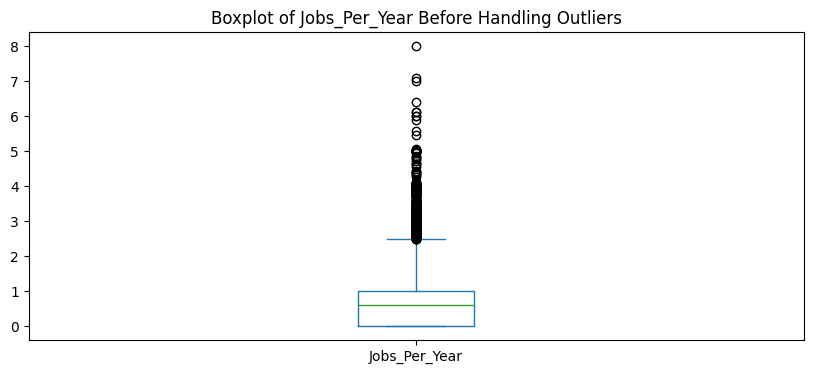

In [11]:

def handle_outliers(df, columns):
    for column in columns:
        if df[column].dtype in ['int64', 'float64']:
            plt.figure(figsize=(10, 4))
            df[column].plot(kind='box')
            plt.title(f'Boxplot of {column} Before Handling Outliers')
            plt.show()

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
handle_outliers(df, numeric_columns)

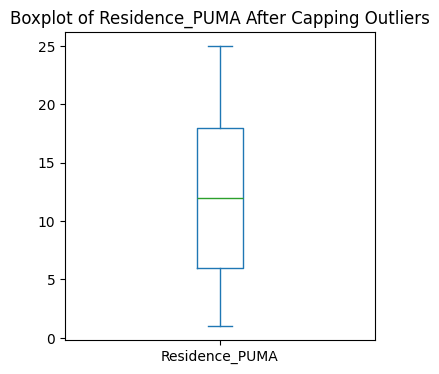

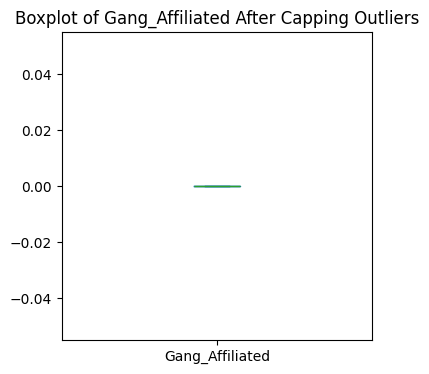

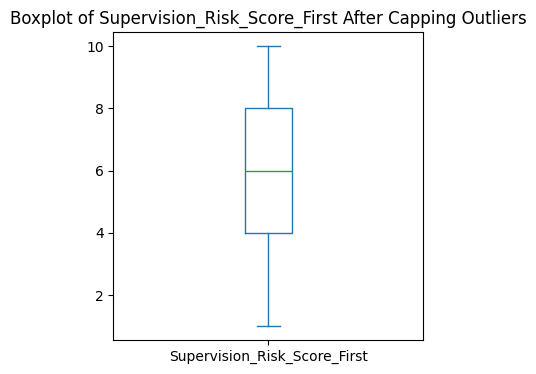

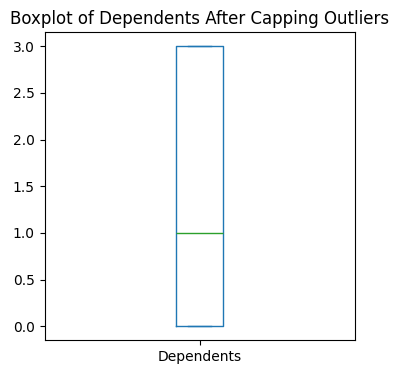

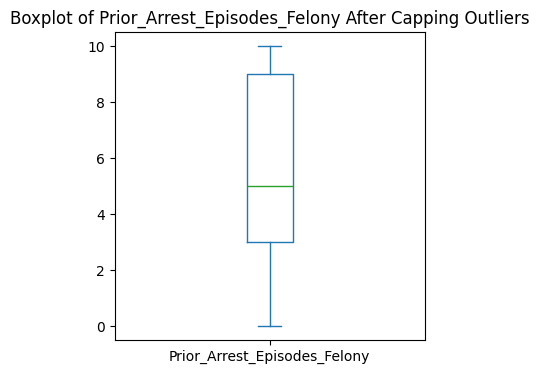

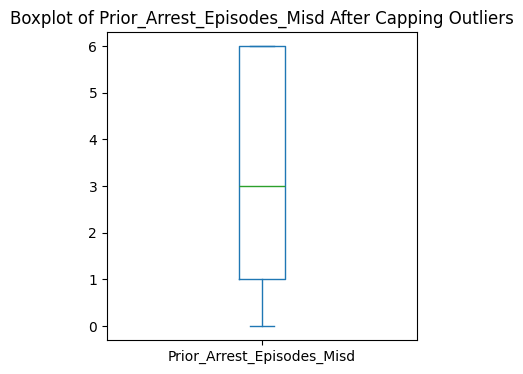

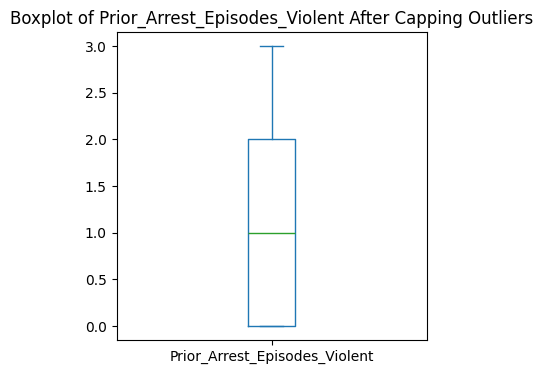

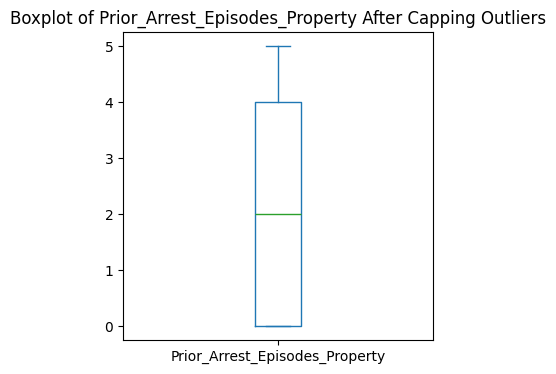

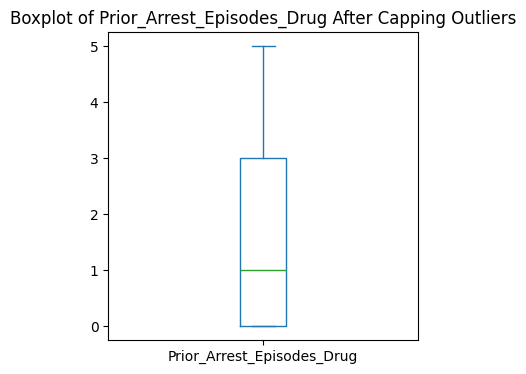

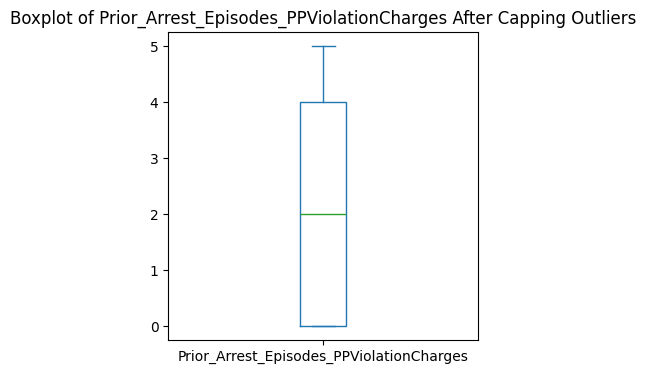

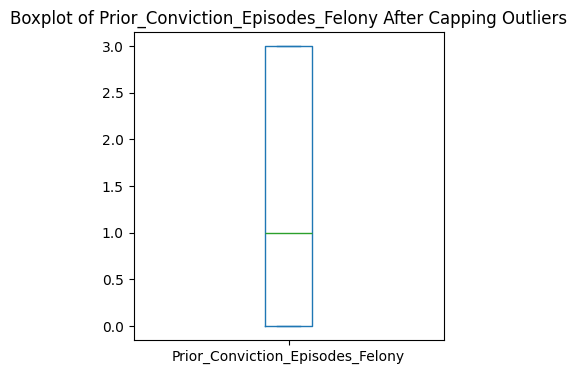

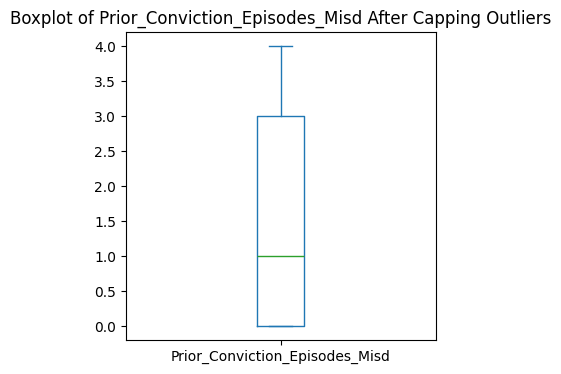

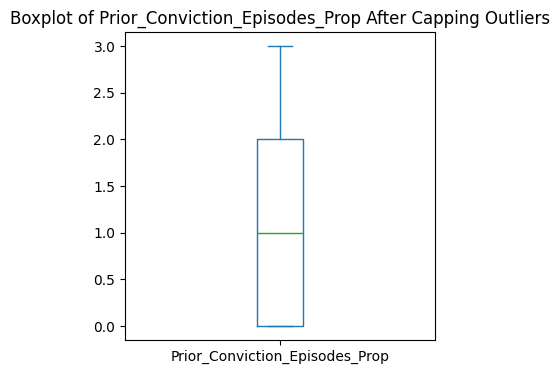

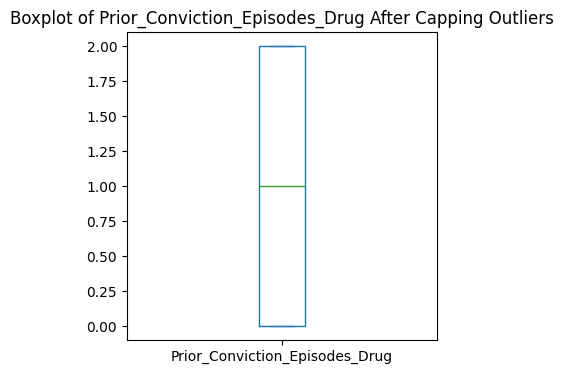

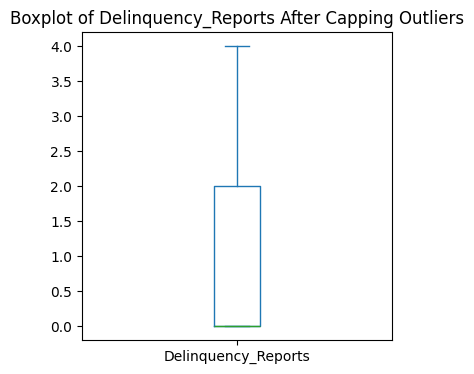

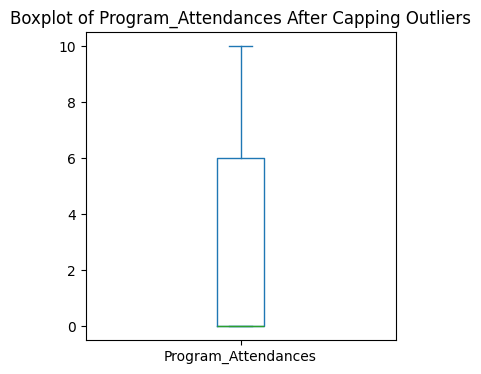

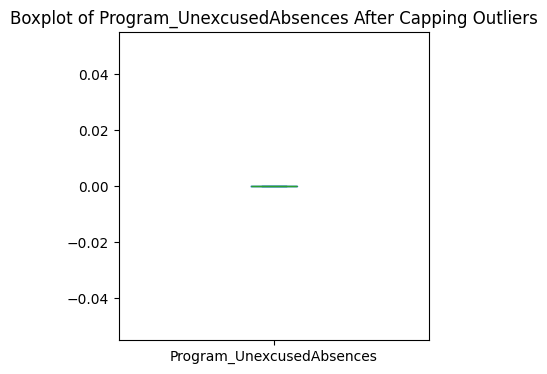

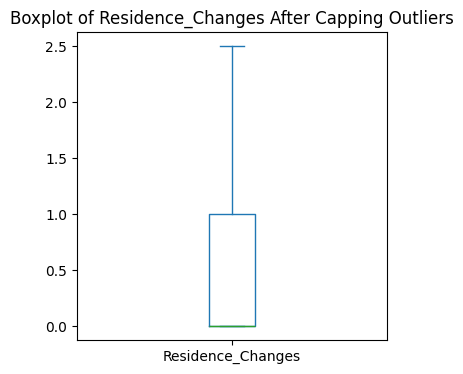

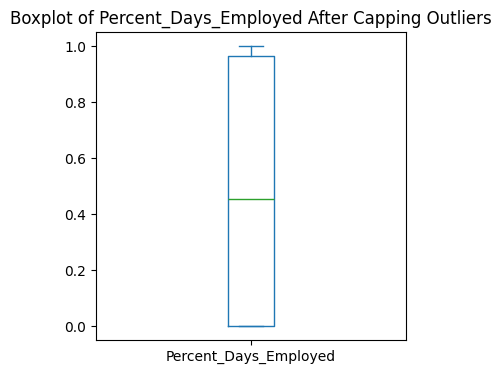

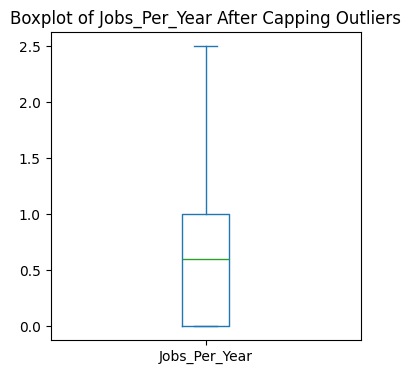

In [12]:
def handle_outliers(df, columns):
    for column in columns:
        if df[column].dtype in ['int64', 'float64']:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            df[column] = df[column].apply(lambda x: min(max(x, lower_bound), upper_bound))

            plt.figure(figsize=(4, 4))
            df[column].plot(kind='box')
            plt.title(f'Boxplot of {column} After Capping Outliers')
            plt.show()

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
handle_outliers(df, numeric_columns)



# II- Feature Engineering  

# 1) Standardisation

In [13]:
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])


# 2) Encoding des variables categoriques

In [14]:
from sklearn.preprocessing import LabelEncoder

def label_encode_categorical(df):
    label_encoder = LabelEncoder()
    categorical_columns = df.select_dtypes(include=['object']).columns  # Select columns with object dtype (categorical)
    
    for column in categorical_columns:
        df[column] = label_encoder.fit_transform(df[column])
    
    return df

df = label_encode_categorical(df)

#III- EXLORATION DU JEU DE DONNEES

# 1) Histogramme des variables

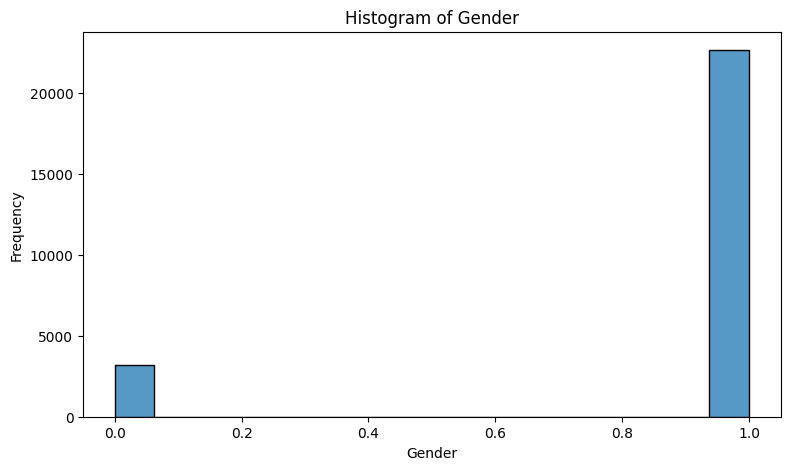

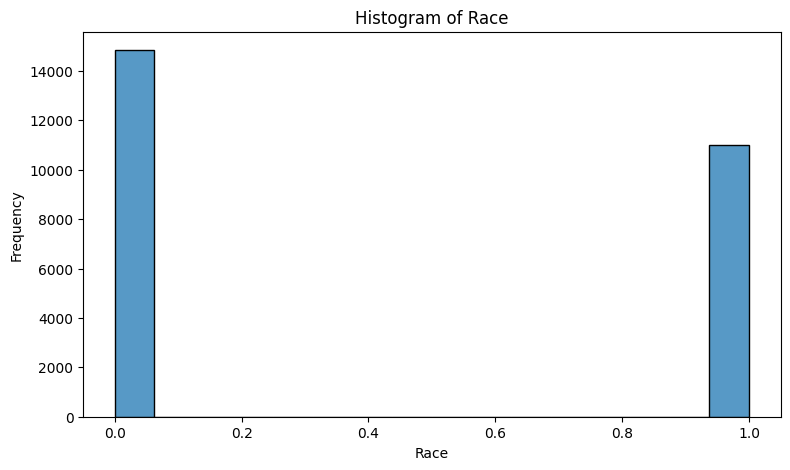

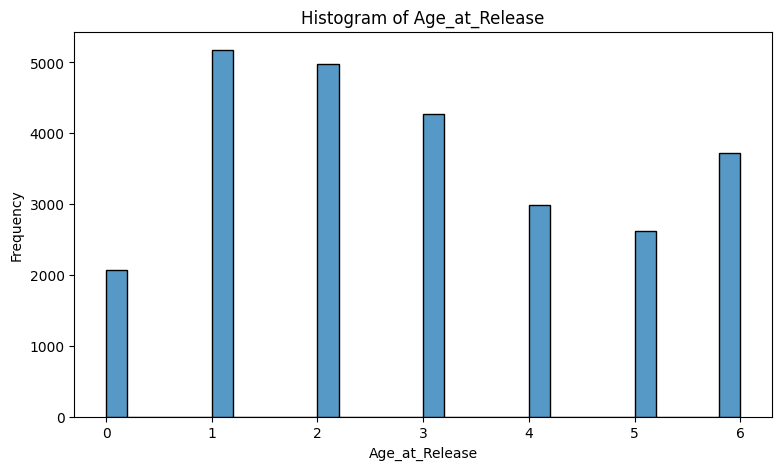

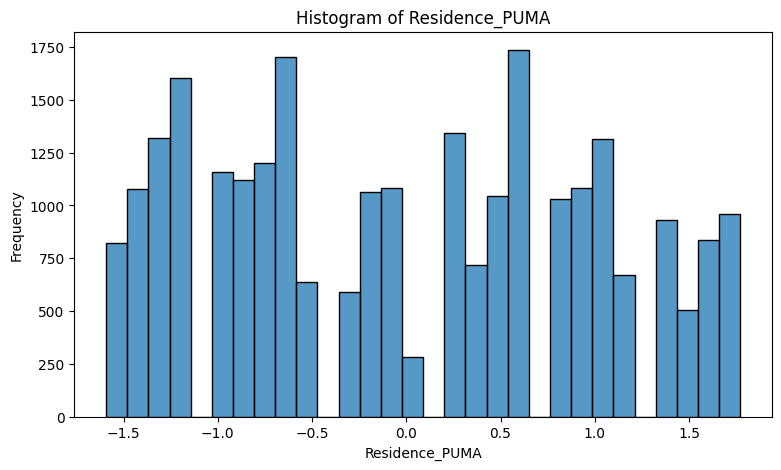

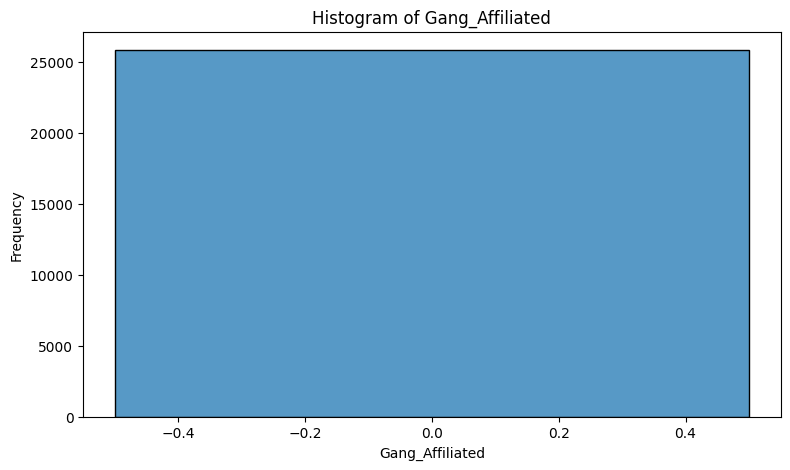

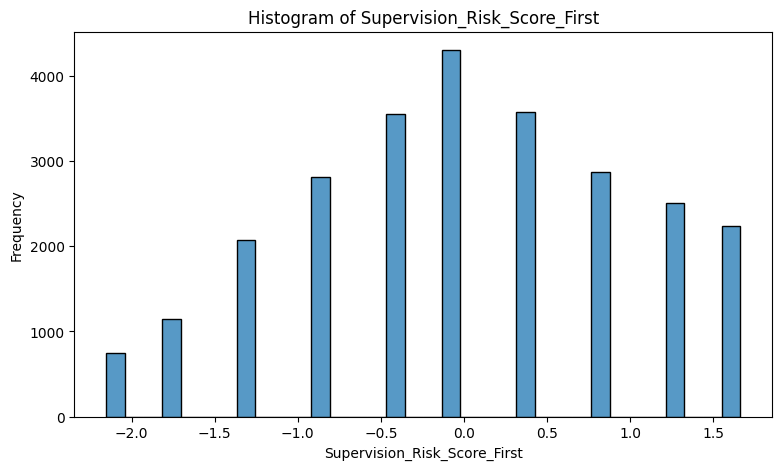

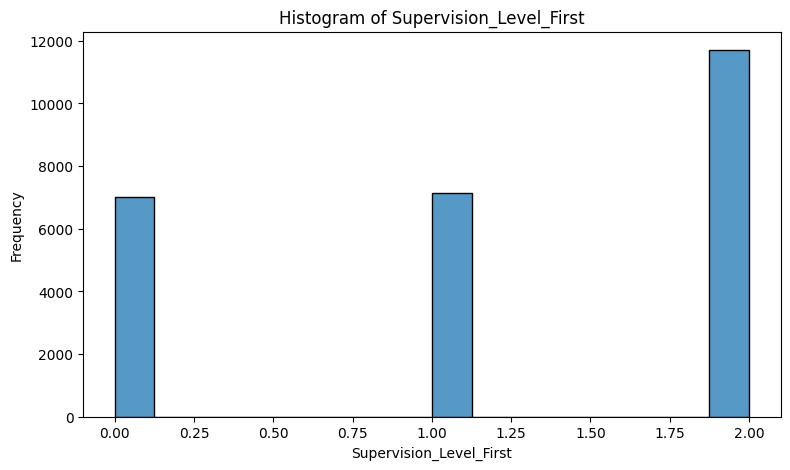

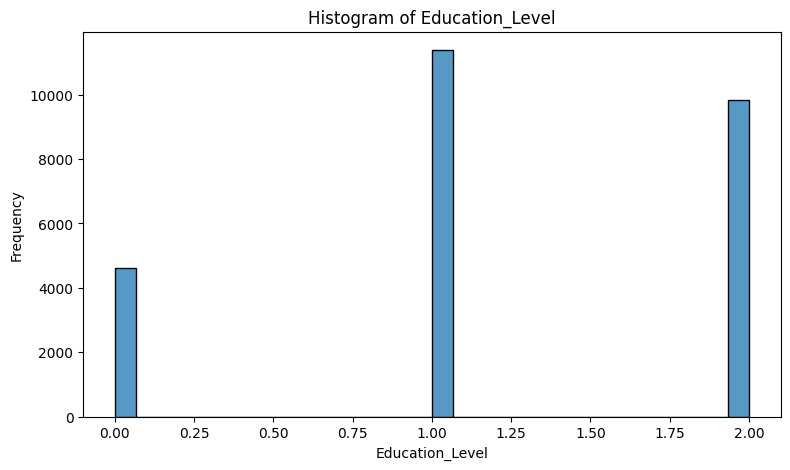

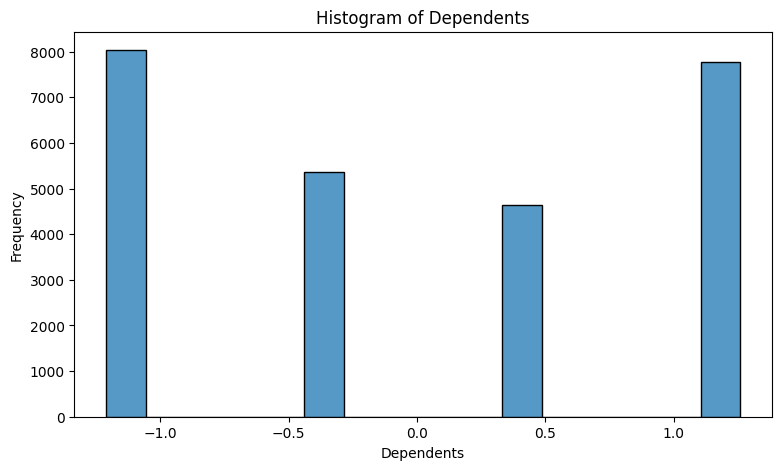

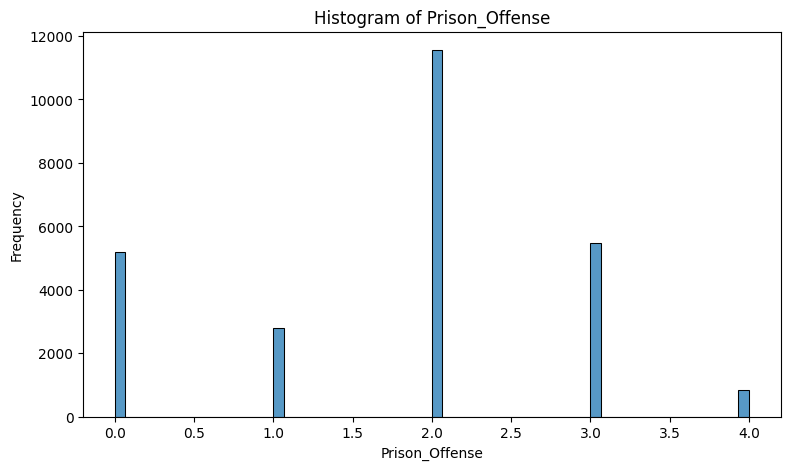

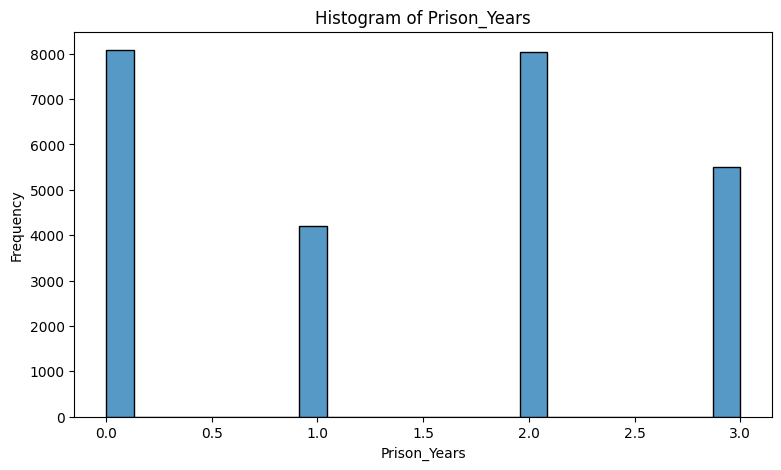

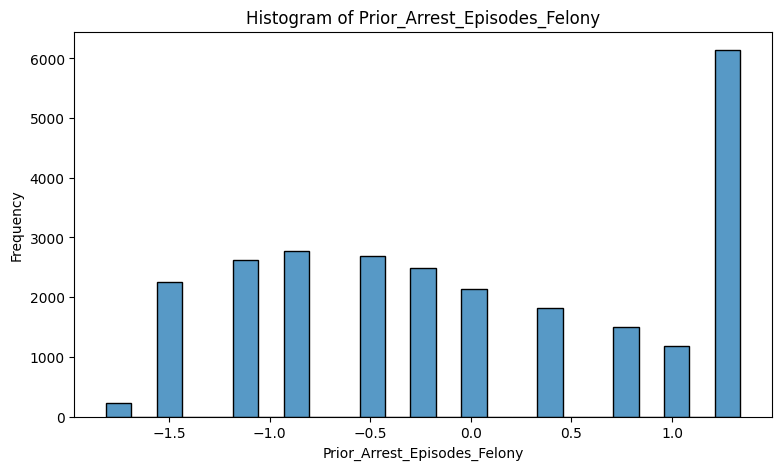

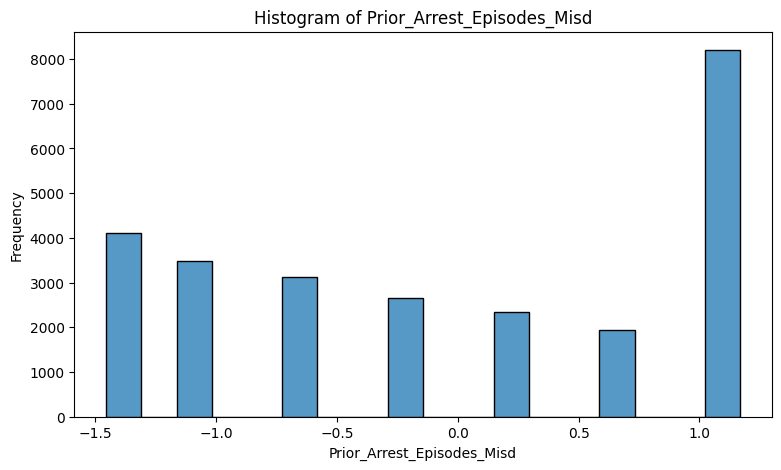

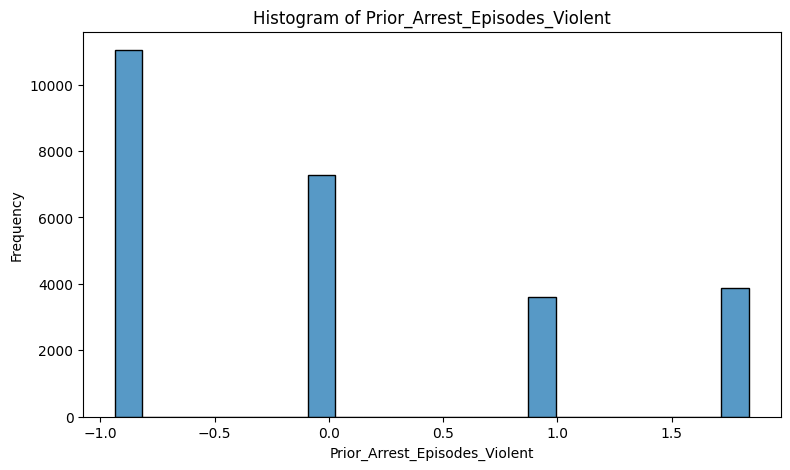

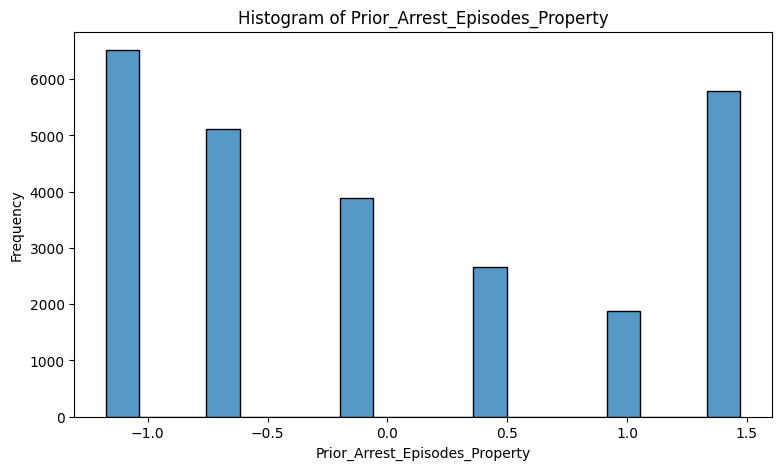

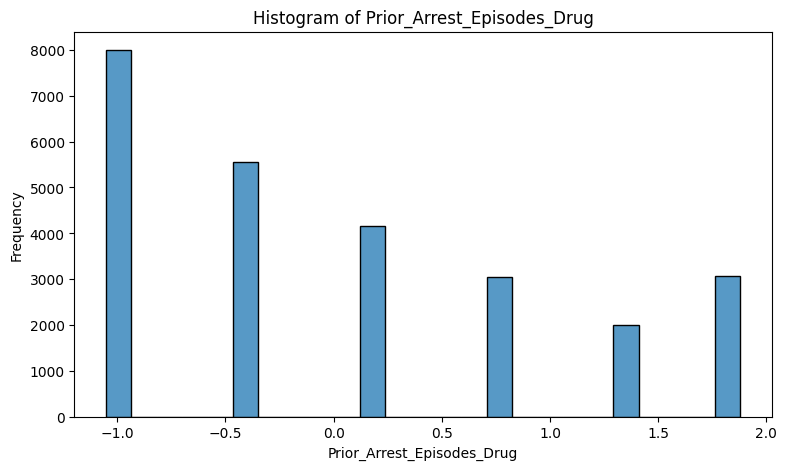

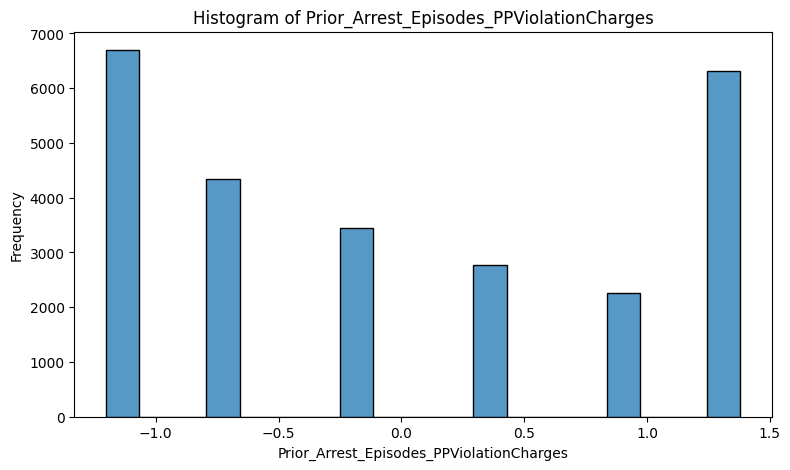

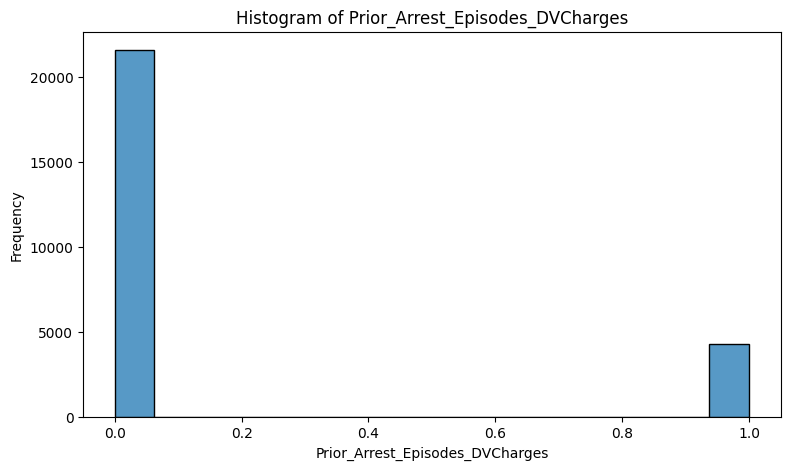

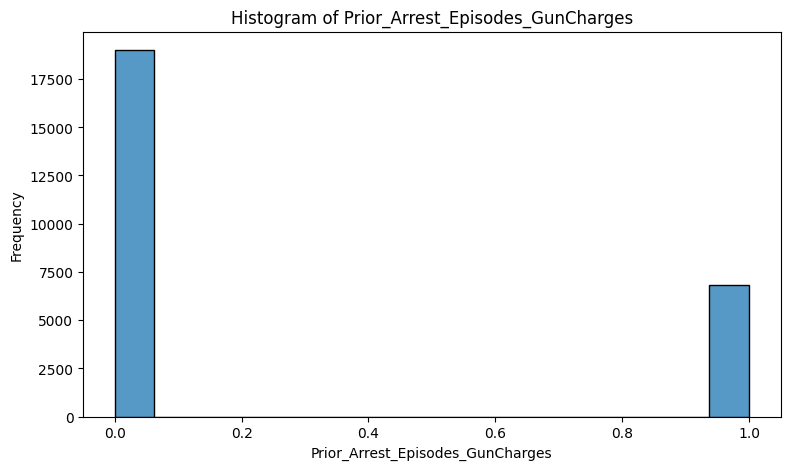

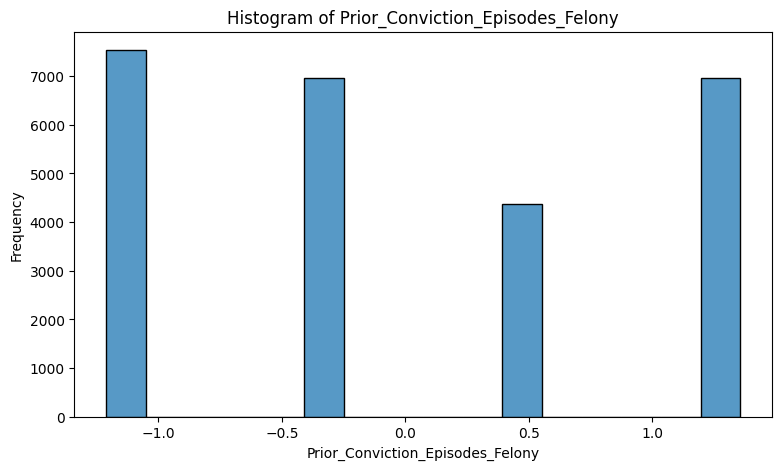

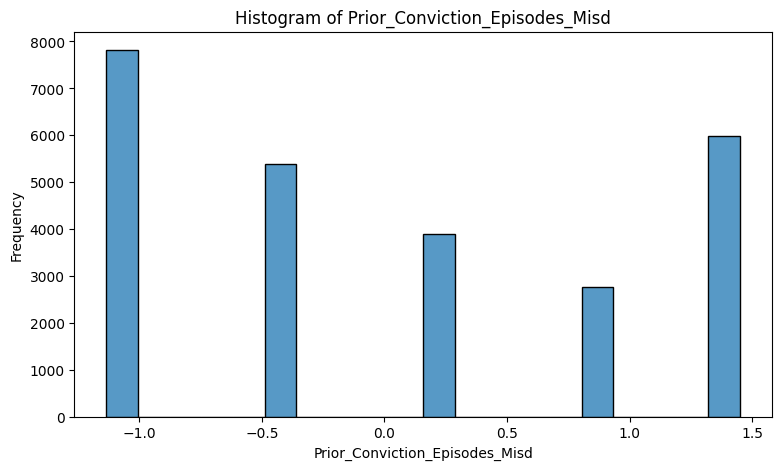

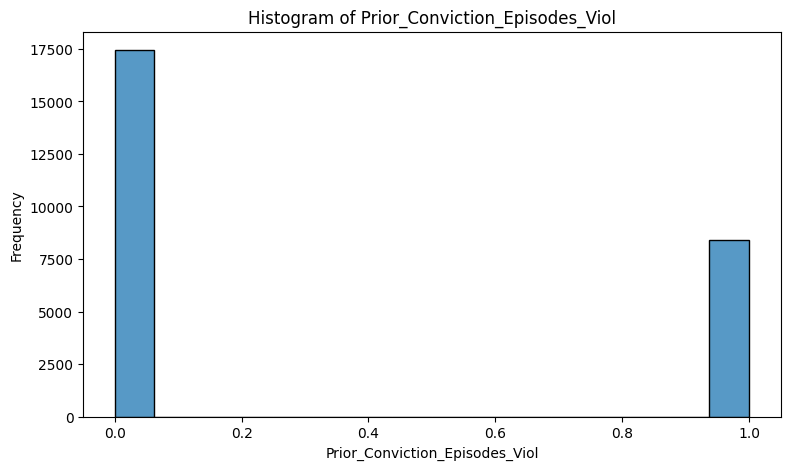

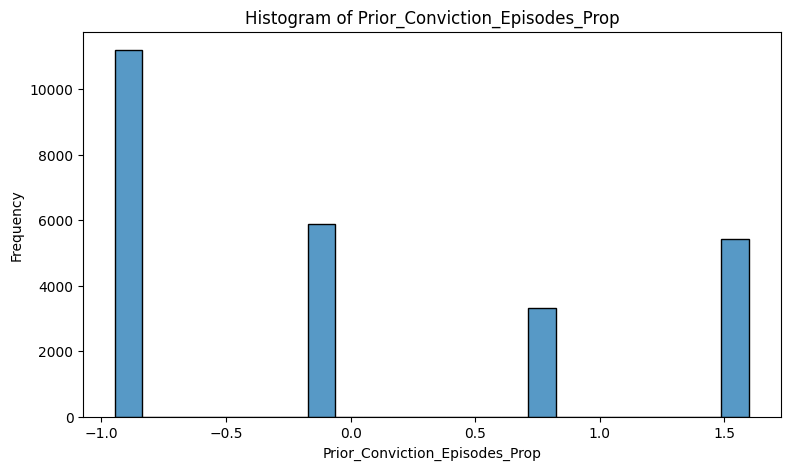

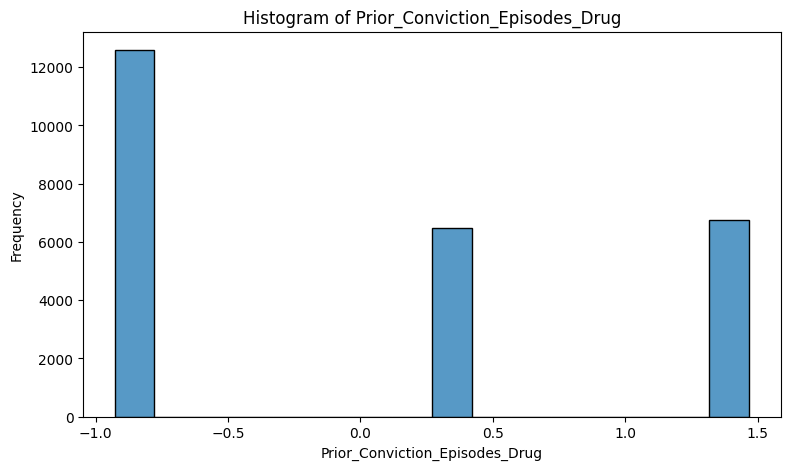

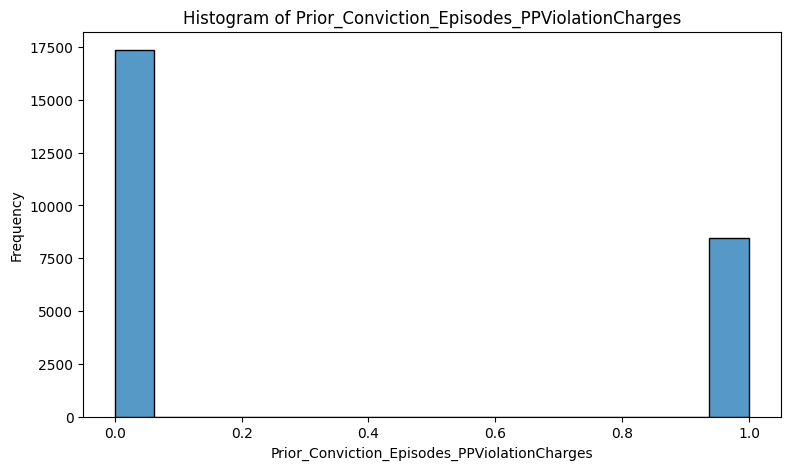

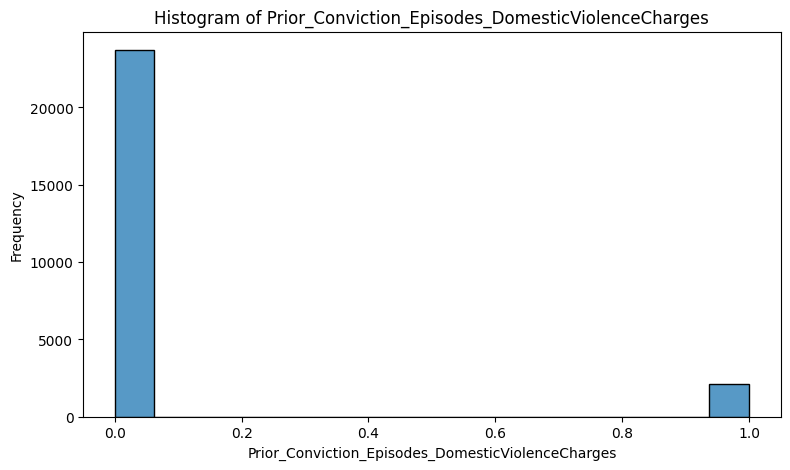

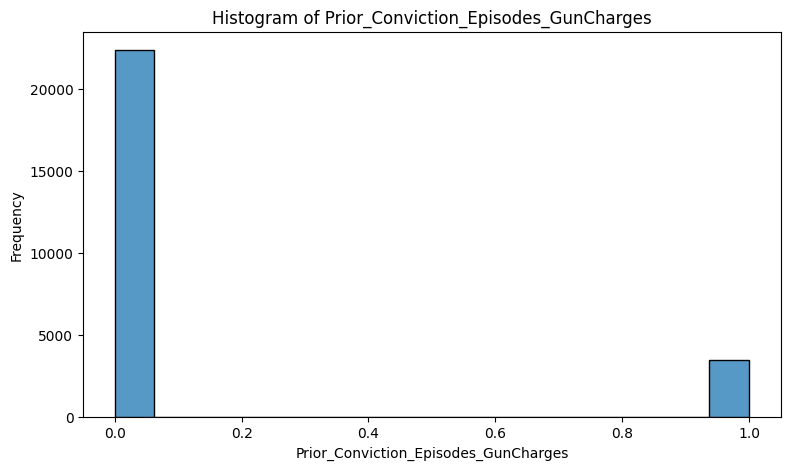

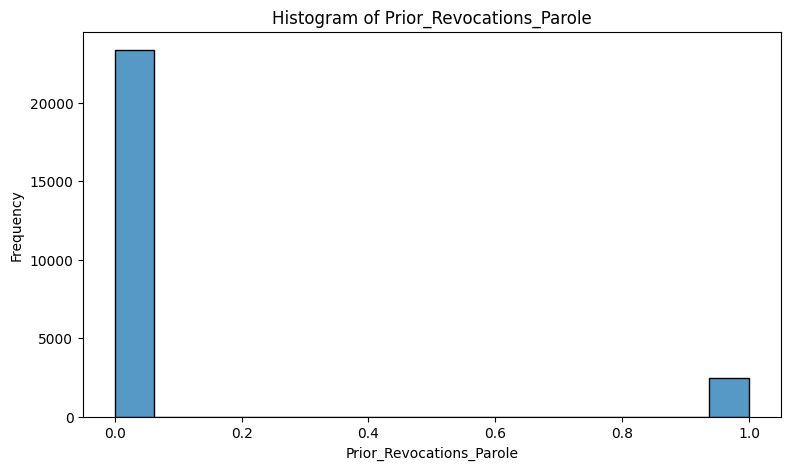

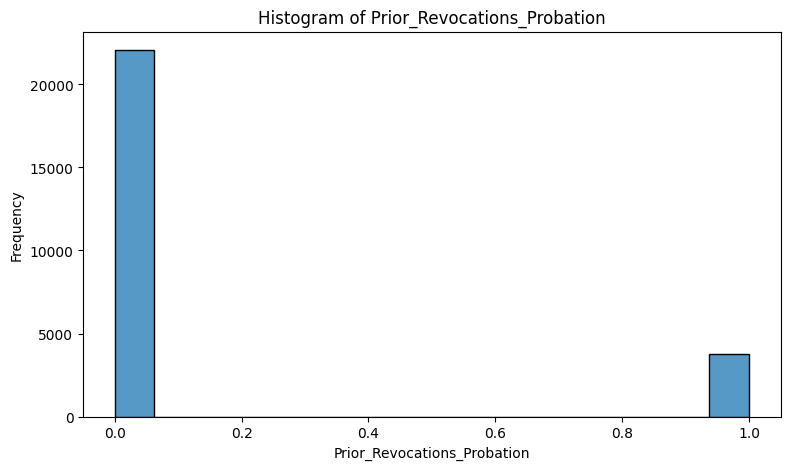

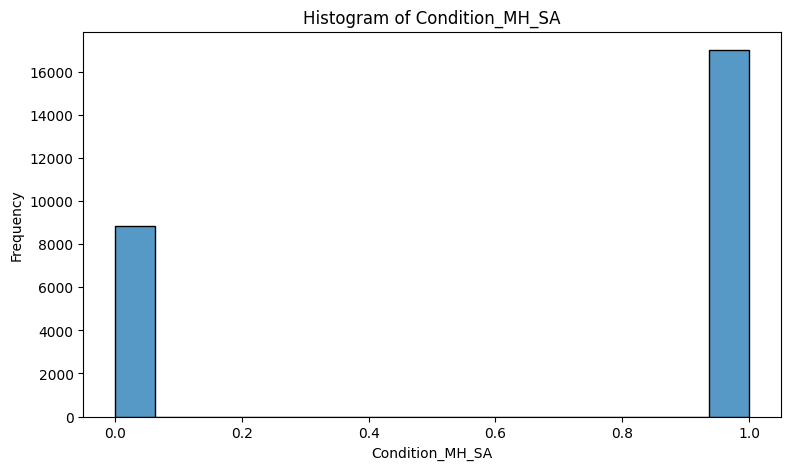

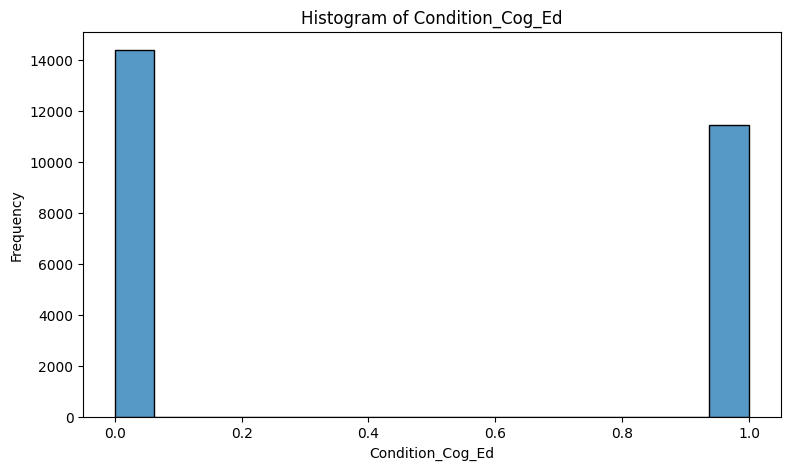

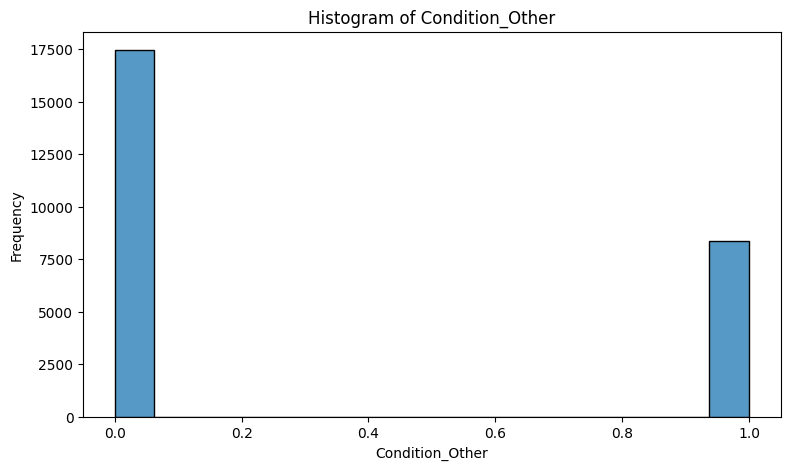

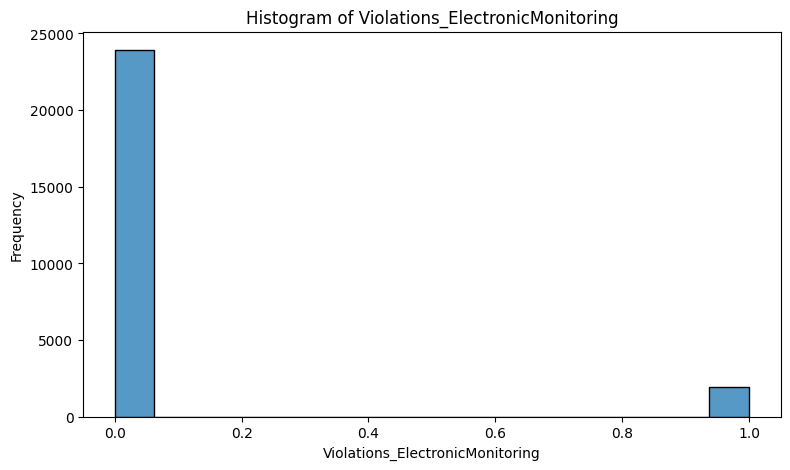

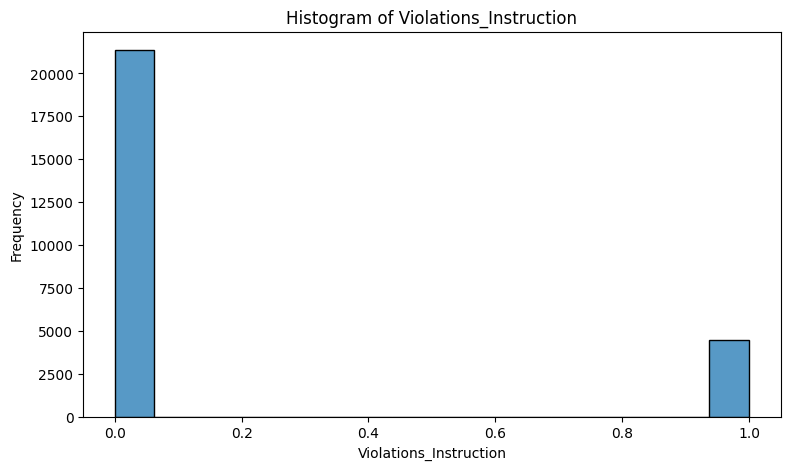

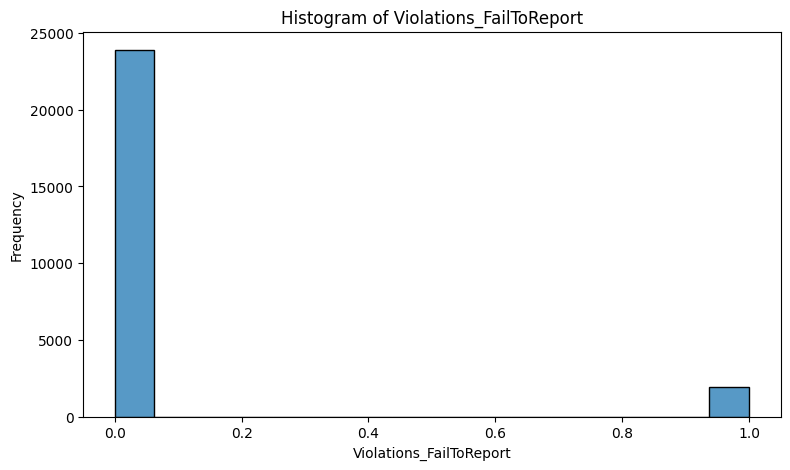

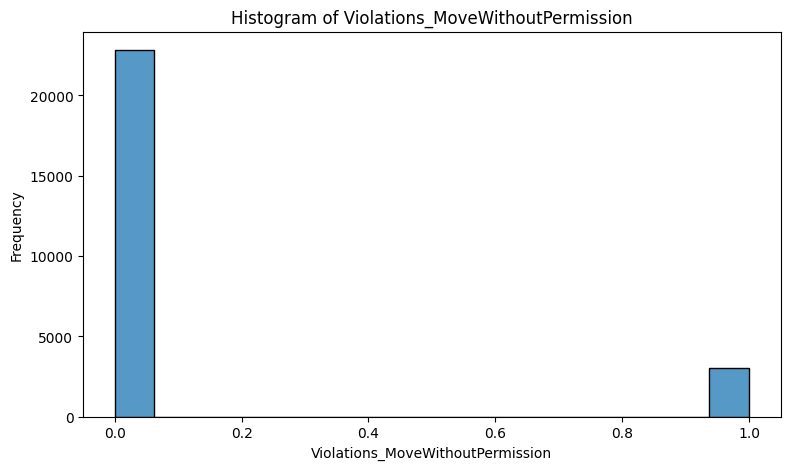

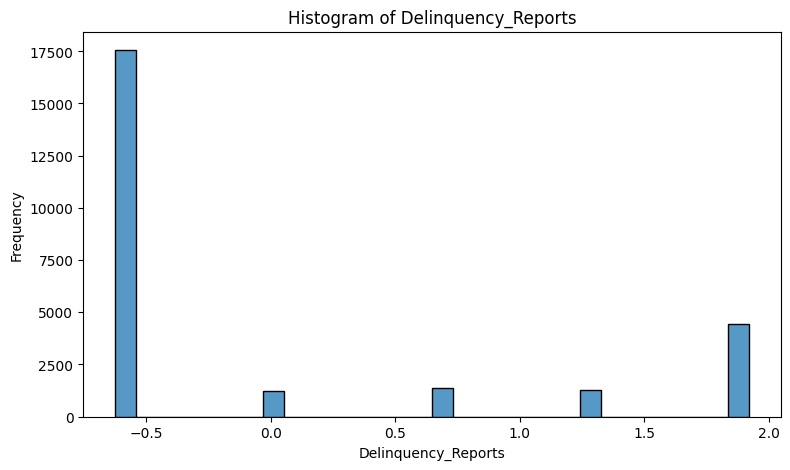

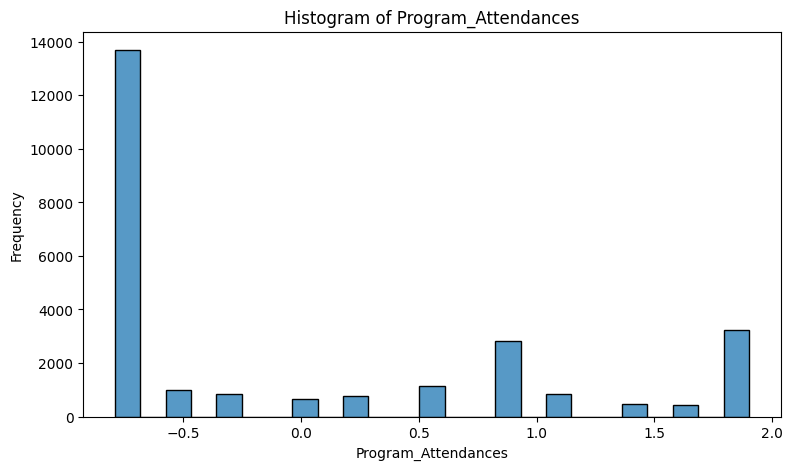

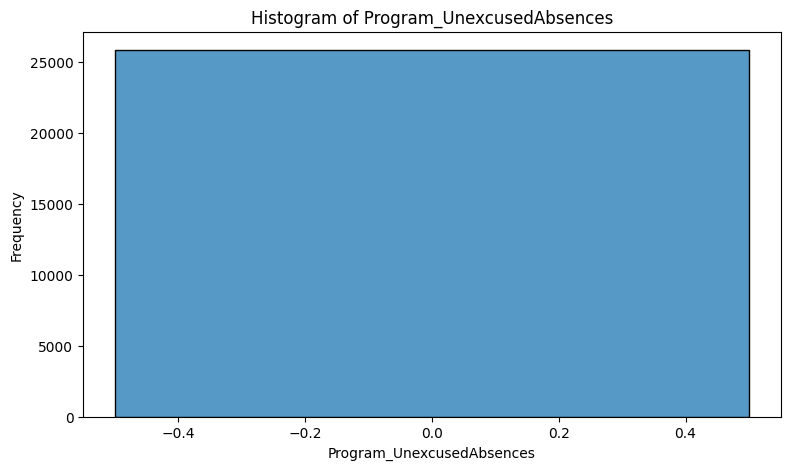

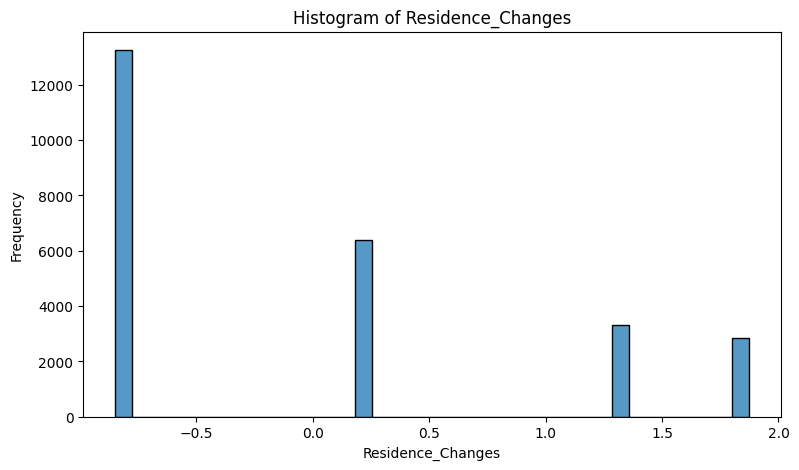

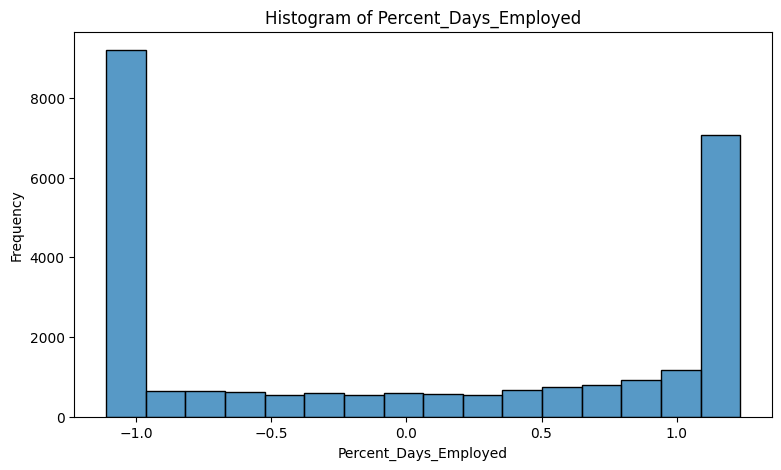

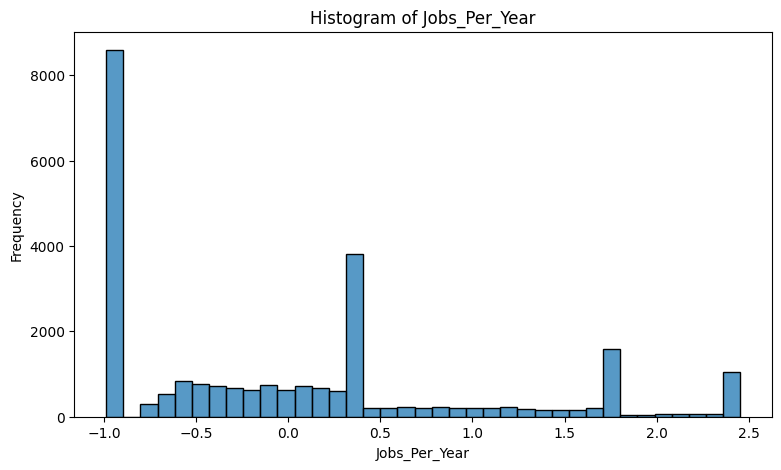

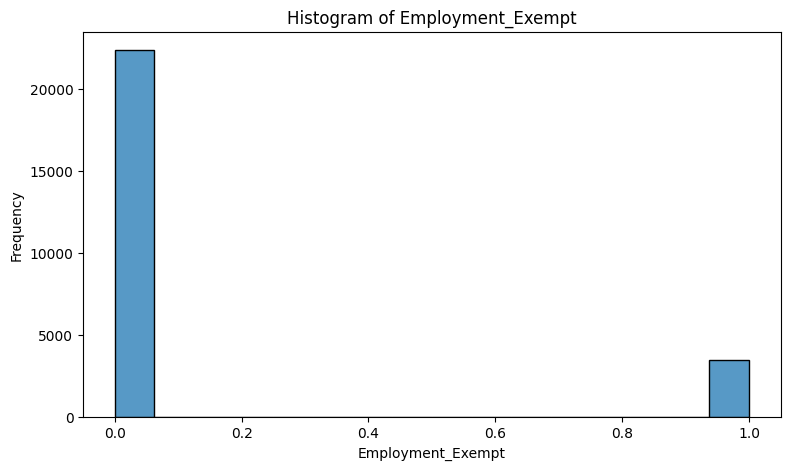

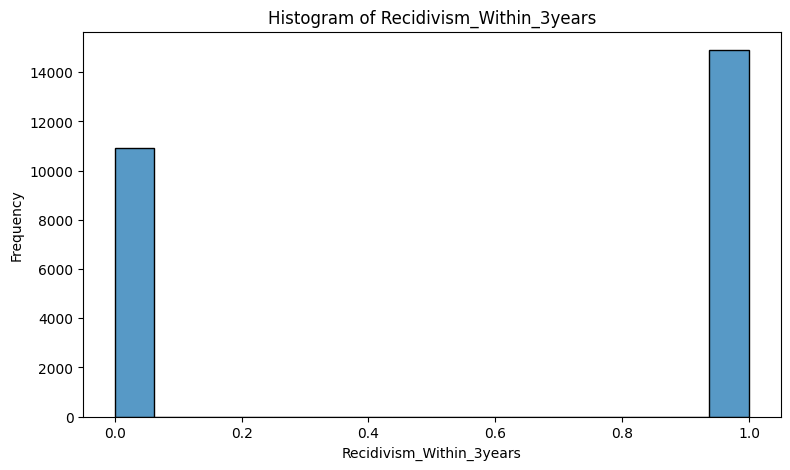

In [15]:
def plot_histograms(df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for column in df.columns:
            plt.figure(figsize=(9, 5))
            sns.histplot(df[column])
            plt.title(f'Histogram of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.show()

plot_histograms(df)

# 2) Matrice de corrélation 

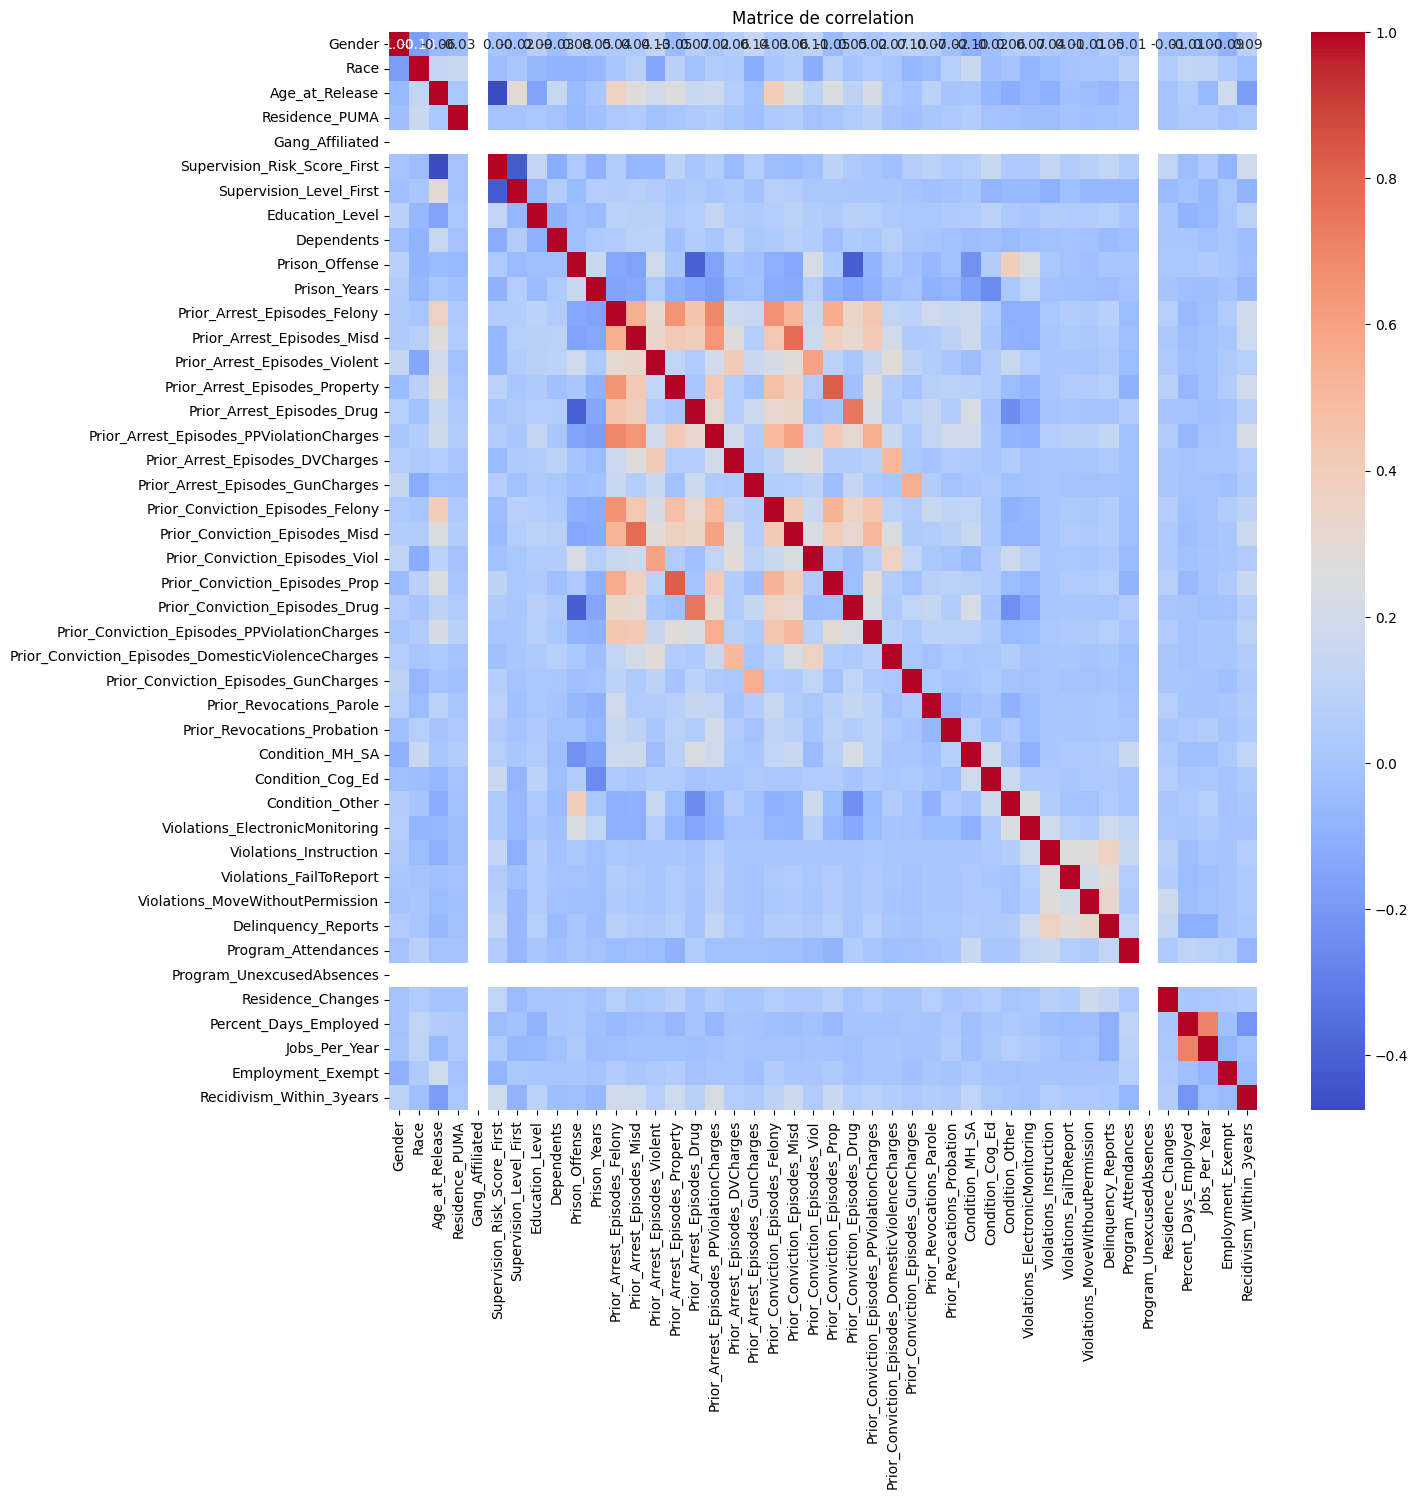

In [16]:
# Correlation matrix
warnings.filterwarnings("ignore", category=FutureWarning)
corr_matrix = df.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de correlation')
plt.show()


->Gender : La faible corrélation négative suggère une légère tendance à ce que les hommes récidivent plus que les femmes.

->Race et Age_at_Release : Montre des corrélations variées mais généralement faibles, indiquant qu'ils peuvent ne pas être les principaux prédicteurs de récidive.

->Residence_PUMA : Montre une corrélation relativement forte, indiquant que l'emplacement résidentiel peut jouer un rôle significatif dans la récidive.

->Épisodes d'Arrestation et de Condamnation : Les nombreuses corrélations positives suggèrent que plus un individu a d'épisodes criminels dans son passé, plus il est susceptible de récidiver.

# !ACP

In [17]:
recidivism = df['Recidivism_Within_3years']
df = df.drop('Recidivism_Within_3years', axis = 1)

In [18]:
#instanciation
acp = PCA()

#Coordonées dans le nouvel espace
coord = acp.fit_transform(df)

cumulative_variance_ratio = np.cumsum(acp.explained_variance_ratio_)
#print(cumulative_variance_ratio)

num_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
print("Le nombre de composantes expliquants au moins 90% de la variance :", num_components_90)


Le nombre de composantes expliquants au moins 90% de la variance : 20


In [19]:
df.head()

,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,...,Violations_Instruction,Violations_FailToReport,Violations_MoveWithoutPermission,Delinquency_Reports,Program_Attendances,Program_UnexcusedAbsences,Residence_Changes,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt
0,1,0,5,0.510009,0.0,-1.305700,2,0,1.259293,0,...,0,0,0,-0.626144,0.825088,0.0,1.328467,0.034875,-0.372086,0
1,1,0,3,0.510009,0.0,-0.034205,1,2,-0.388157,3,...,1,0,0,1.921226,-0.789996,0.0,1.328467,-0.113783,1.765137,0
2,1,0,6,1.631462,0.0,0.389627,0,0,1.259293,0,...,1,0,1,1.921226,0.825088,0.0,-0.850710,-1.111980,-0.988325,0
3,1,1,4,0.510009,0.0,0.389627,0,2,-0.388157,2,...,0,0,0,-0.626144,0.825088,0.0,1.873261,1.235430,0.001539,0
4,1,1,3,0.510009,0.0,-0.881869,1,2,1.259293,3,...,0,0,0,-0.626144,1.094269,0.0,-0.850710,-0.634136,0.291194,0


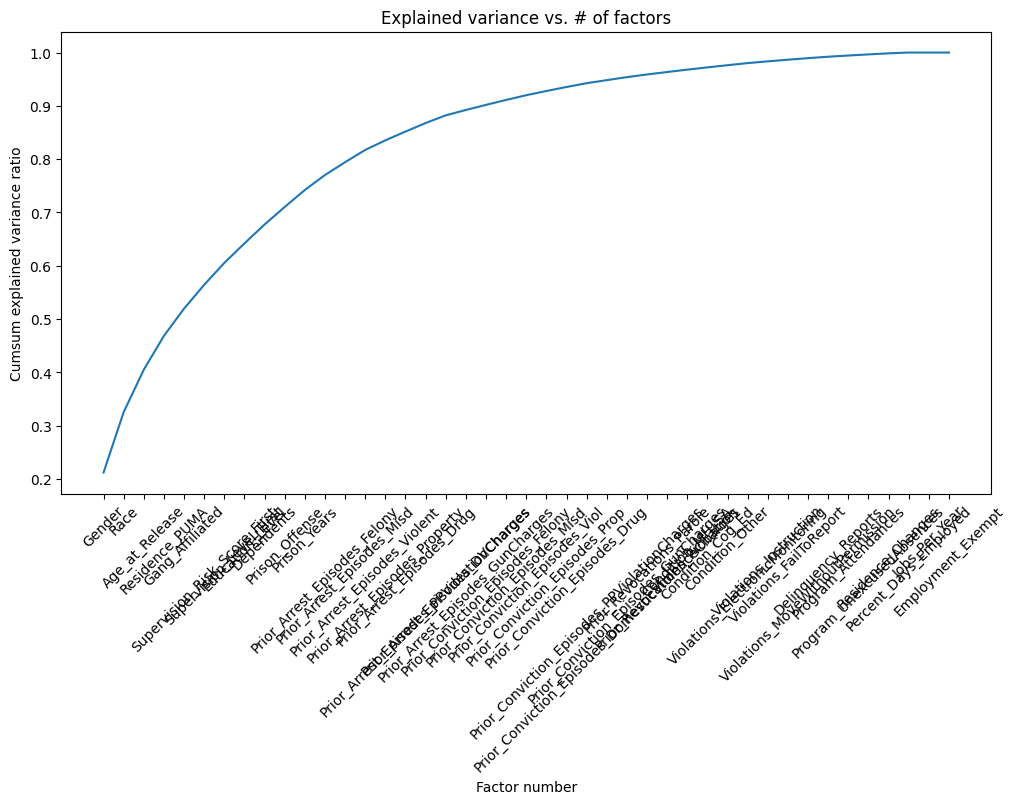

In [20]:
import matplotlib.pyplot as plt
import numpy as np

#cumul de variance expliquée
list_acp  = [
    "Gender", "Race", "Age_at_Release", "Residence_PUMA", "Gang_Affiliated",
    "Supervision_Risk_Score_First", "Supervision_Level_First", "Education_Level", "Dependents",
    "Prison_Offense", "Prison_Years", "Prior_Arrest_Episodes_Felony", "Prior_Arrest_Episodes_Misd",
    "Prior_Arrest_Episodes_Violent", "Prior_Arrest_Episodes_Property", "Prior_Arrest_Episodes_Drug",
    "Prior_Arrest_Episodes_PPViolationCharges", "Prior_Arrest_Episodes_DVCharges",
    "Prior_Arrest_Episodes_GunCharges", "Prior_Conviction_Episodes_Felony",
    "Prior_Conviction_Episodes_Misd", "Prior_Conviction_Episodes_Viol",
    "Prior_Conviction_Episodes_Prop", "Prior_Conviction_Episodes_Drug",
    "Prior_Conviction_Episodes_PPViolationCharges", "Prior_Conviction_Episodes_DomesticViolenceCharges",
    "Prior_Conviction_Episodes_GunCharges", "Prior_Revocations_Parole", "Prior_Revocations_Probation",
    "Condition_MH_SA", "Condition_Cog_Ed", "Condition_Other", "Violations_ElectronicMonitoring",
    "Violations_Instruction", "Violations_FailToReport", "Violations_MoveWithoutPermission",
    "Delinquency_Reports", "Program_Attendances", "Program_UnexcusedAbsences", "Residence_Changes",
 "Percent_Days_Employed", "Jobs_Per_Year", "Employment_Exempt",
]
num_factors = min(len(acp.explained_variance_ratio_), len(list_acp))
plt.figure(figsize=(12, 6)) 
plt.plot(range(1, num_factors + 1), np.cumsum(acp.explained_variance_ratio_[:num_factors]))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")

# Use actual column names from your dataset
plt.xticks(range(1, num_factors + 1), list_acp[:num_factors], rotation=45)
plt.show()

Tout comme dans le code precedant , on remarque 90% de la variabilite est explique par 22 variables rt donce dans ce qui suit , on va prendre uniquement celles-ci .

# Individus

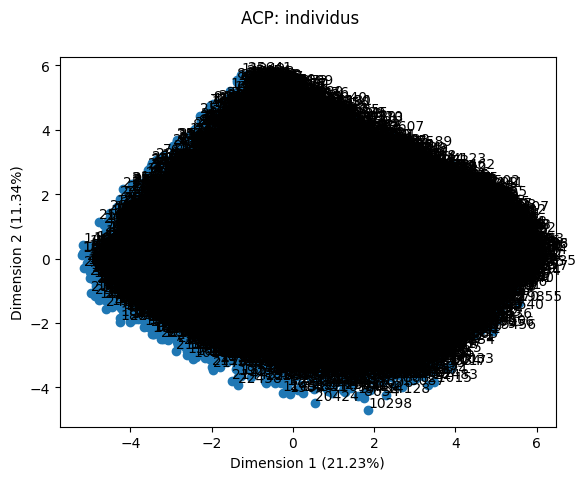

In [21]:
# Plotting scatter plot for the first and second principal components
plt.scatter(coord[:,0], coord[:,1])

# Percentage of variance explained by the first and second principal components
pr1 = round(acp.explained_variance_ratio_[0] * 100, 2)
pr2 = round(acp.explained_variance_ratio_[1] * 100, 2)

# Loop for annotation of all points
for i in range(len(coord)):
    plt.annotate(df.index[i], (coord[i,0], coord[i,1] + 0.1))

# Adding labels and title
plt.xlabel(f"Dimension 1 ({pr1}%)") 
plt.ylabel(f"Dimension 2 ({pr2}%)") 
plt.suptitle("ACP: individus") 

# Show plot
plt.show()

# Variables

In [22]:
acp.explained_variance_

array([5.93209293e+00, 3.16845695e+00, 2.22371438e+00, 1.77299968e+00,
       1.42825701e+00, 1.24733188e+00, 1.14881934e+00, 1.02106341e+00,
       9.90060994e-01, 9.20844086e-01, 8.87752827e-01, 7.85928027e-01,
       6.70672251e-01, 6.44383418e-01, 5.02203314e-01, 4.58386619e-01,
       4.48794170e-01, 4.02275479e-01, 2.81116700e-01, 2.69010664e-01,
       2.57320812e-01, 2.48772299e-01, 2.19361764e-01, 2.11166332e-01,
       1.98404570e-01, 1.59688125e-01, 1.58106284e-01, 1.39846504e-01,
       1.27281340e-01, 1.26579749e-01, 1.17254348e-01, 1.14207081e-01,
       1.10298038e-01, 9.19480343e-02, 8.62683521e-02, 8.12127093e-02,
       7.51299185e-02, 6.20572213e-02, 5.90232962e-02, 5.58979711e-02,
       4.21140115e-02, 1.16989905e-30, 2.53178951e-32])

In [23]:
variables_acp = df.iloc[:, :22]
new_df = pd.concat([variables_acp,recidivism], axis=1)

new_df.head()

,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,Prison_Offense,...,Prior_Arrest_Episodes_Violent,Prior_Arrest_Episodes_Property,Prior_Arrest_Episodes_Drug,Prior_Arrest_Episodes_PPViolationCharges,Prior_Arrest_Episodes_DVCharges,Prior_Arrest_Episodes_GunCharges,Prior_Conviction_Episodes_Felony,Prior_Conviction_Episodes_Misd,Prior_Conviction_Episodes_Viol,Recidivism_Within_3years
0,1,0,5,0.510009,0.0,-1.305700,2,0,1.259293,0,...,-0.012029,0.413624,0.706945,0.862844,0,0,1.355426,0.804196,0,0
1,1,0,3,0.510009,0.0,-0.034205,1,2,-0.388157,3,...,1.837747,-1.174110,0.706945,1.378972,1,0,1.355426,1.450691,1,1
2,1,0,6,1.631462,0.0,0.389627,0,0,1.259293,0,...,1.837747,-0.115621,0.120642,1.378972,1,0,1.355426,0.157701,1,1
3,1,1,4,0.510009,0.0,0.389627,0,2,-0.388157,2,...,-0.936917,0.413624,0.706945,0.346716,0,0,1.355426,1.450691,0,0
4,1,1,3,0.510009,0.0,-0.881869,1,2,1.259293,3,...,1.837747,-0.115621,-0.465661,0.346716,1,0,-0.356206,-1.135289,1,1


# !Regression logistique 

# 1-Objectif

Cet algorithme est appliqué pour repondre a la question suivante :

    1-C'est quoi la probabilite qu'un individu recedive apres 3 ans en se basant sur ces caracteristiques ?

# 2-Application

In [24]:
#Split des données 
X = variables_acp
y = recidivism
train_X, test_X, train_y, test_y = train_test_split( X, y, test_size=0.20,random_state=0)

In [25]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression() 
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)

print(accuracy)


0.6754402941745694


Le modele est capable de predire correctement la recidive pour environ 68% des inddividus 

In [26]:
# Extracting feature importance
feature_importance = lr.coef_[0]
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                                     Feature  Importance
0                                     Gender    0.489288
11              Prior_Arrest_Episodes_Felony    0.239892
14            Prior_Arrest_Episodes_Property    0.221547
16  Prior_Arrest_Episodes_PPViolationCharges    0.197404
12                Prior_Arrest_Episodes_Misd    0.132556
5               Supervision_Risk_Score_First    0.084597
20            Prior_Conviction_Episodes_Misd    0.079803
21            Prior_Conviction_Episodes_Viol    0.052080
3                             Residence_PUMA    0.045396
17           Prior_Arrest_Episodes_DVCharges    0.036433
13             Prior_Arrest_Episodes_Violent    0.026243
7                            Education_Level    0.018745
1                                       Race    0.015262
19          Prior_Conviction_Episodes_Felony    0.014749
8                                 Dependents    0.007760
4                            Gang_Affiliated    0.000000
10                             

D'apres ces resultats : 

    -Le genre est la caracteristique la plus influente dans la precection pour ce model ; c-a-d les individus d un sexe ont une probabilite plus elevee de recedive par rapport a l autre sexe .
    -Age_at_Release et Supervision_Level_First ont des coefficients negatifs , cela signifie que une valeur elevee pour c'est 2 caracteristiques est associee a une probabilite puls faible de recidive .

In [27]:
from sklearn.metrics import classification_report
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.64      0.48      0.55      2128
           1       0.69      0.81      0.75      3039

    accuracy                           0.68      5167
   macro avg       0.67      0.65      0.65      5167
weighted avg       0.67      0.68      0.66      5167



D'apres les resultats , on remarque que le modele est plus performant pour predire la classe 1 que la classe 0 , comme indique par les scores plus eleves de la classe 1 .

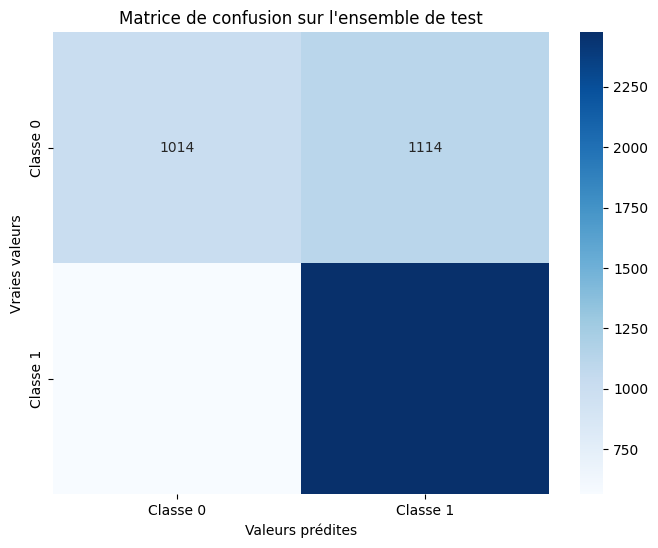

In [28]:
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
cm = confusion_matrix(test_y, predictions)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Valeurs prédites')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion sur l\'ensemble de test')
plt.show()


-Le modele a correctement predit que 1014 individus ne recidiveraient pas.

-Le modele a incorrectement predit que 1114 individus recidiveraient , alors qu'ils ne l'ont pas fait .

-Le modèle a incorrectement prédit que 1127 individus ne récidiveraient pas (Classe 0), alors qu'ils ont récidivé (Classe 1).

-Le modèle a correctement prédit que 1912 individus récidiveraient (Classe 1).

# !Decision Tree

# 1-Objectif de l'algorithme 

-Quels sont les facteurs les plus importants qui influencent la probabilité de récidive ?

-Quelle est la probabilité qu'un individu récidive en fonction de ses caractéristiques ?

Quelle est la probabilité qu'un individu récidive en fonction de ses caractéristiques ?

# 2-Application

In [29]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, mean_squared_error
import warnings
from sklearn.metrics import accuracy_score, mean_squared_error

In [30]:
#Split des données 
X = variables_acp
y = recidivism
train_X, test_X, train_y, test_y = train_test_split( X, y, test_size=0.20,random_state=0)

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)

grid_search.fit(train_X, train_y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score: 0.6600059277218269


In [32]:
dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
dt.fit(train_X, train_y)
# Prédiction sur les données de test
y_pred = dt.predict(test_X)

# Évaluation du modèle
accuracy = accuracy_score(test_y, y_pred)
print(f'Accuracy: {accuracy}')

print(classification_report(test_y, y_pred))

Accuracy: 0.6584091348945229
              precision    recall  f1-score   support

           0       0.62      0.46      0.52      2128
           1       0.68      0.80      0.73      3039

    accuracy                           0.66      5167
   macro avg       0.65      0.63      0.63      5167
weighted avg       0.65      0.66      0.65      5167



-La precision de 66% signifie que le modele classifie correctement environ 66% des exemples de test.

-Comme pour la regression logistique , on remarque une  meilleure performance au niveau de l'identification  les récidivistes que les non-récidiviste .

In [33]:
#pip install pydotplus

In [34]:
#pip install graphviz

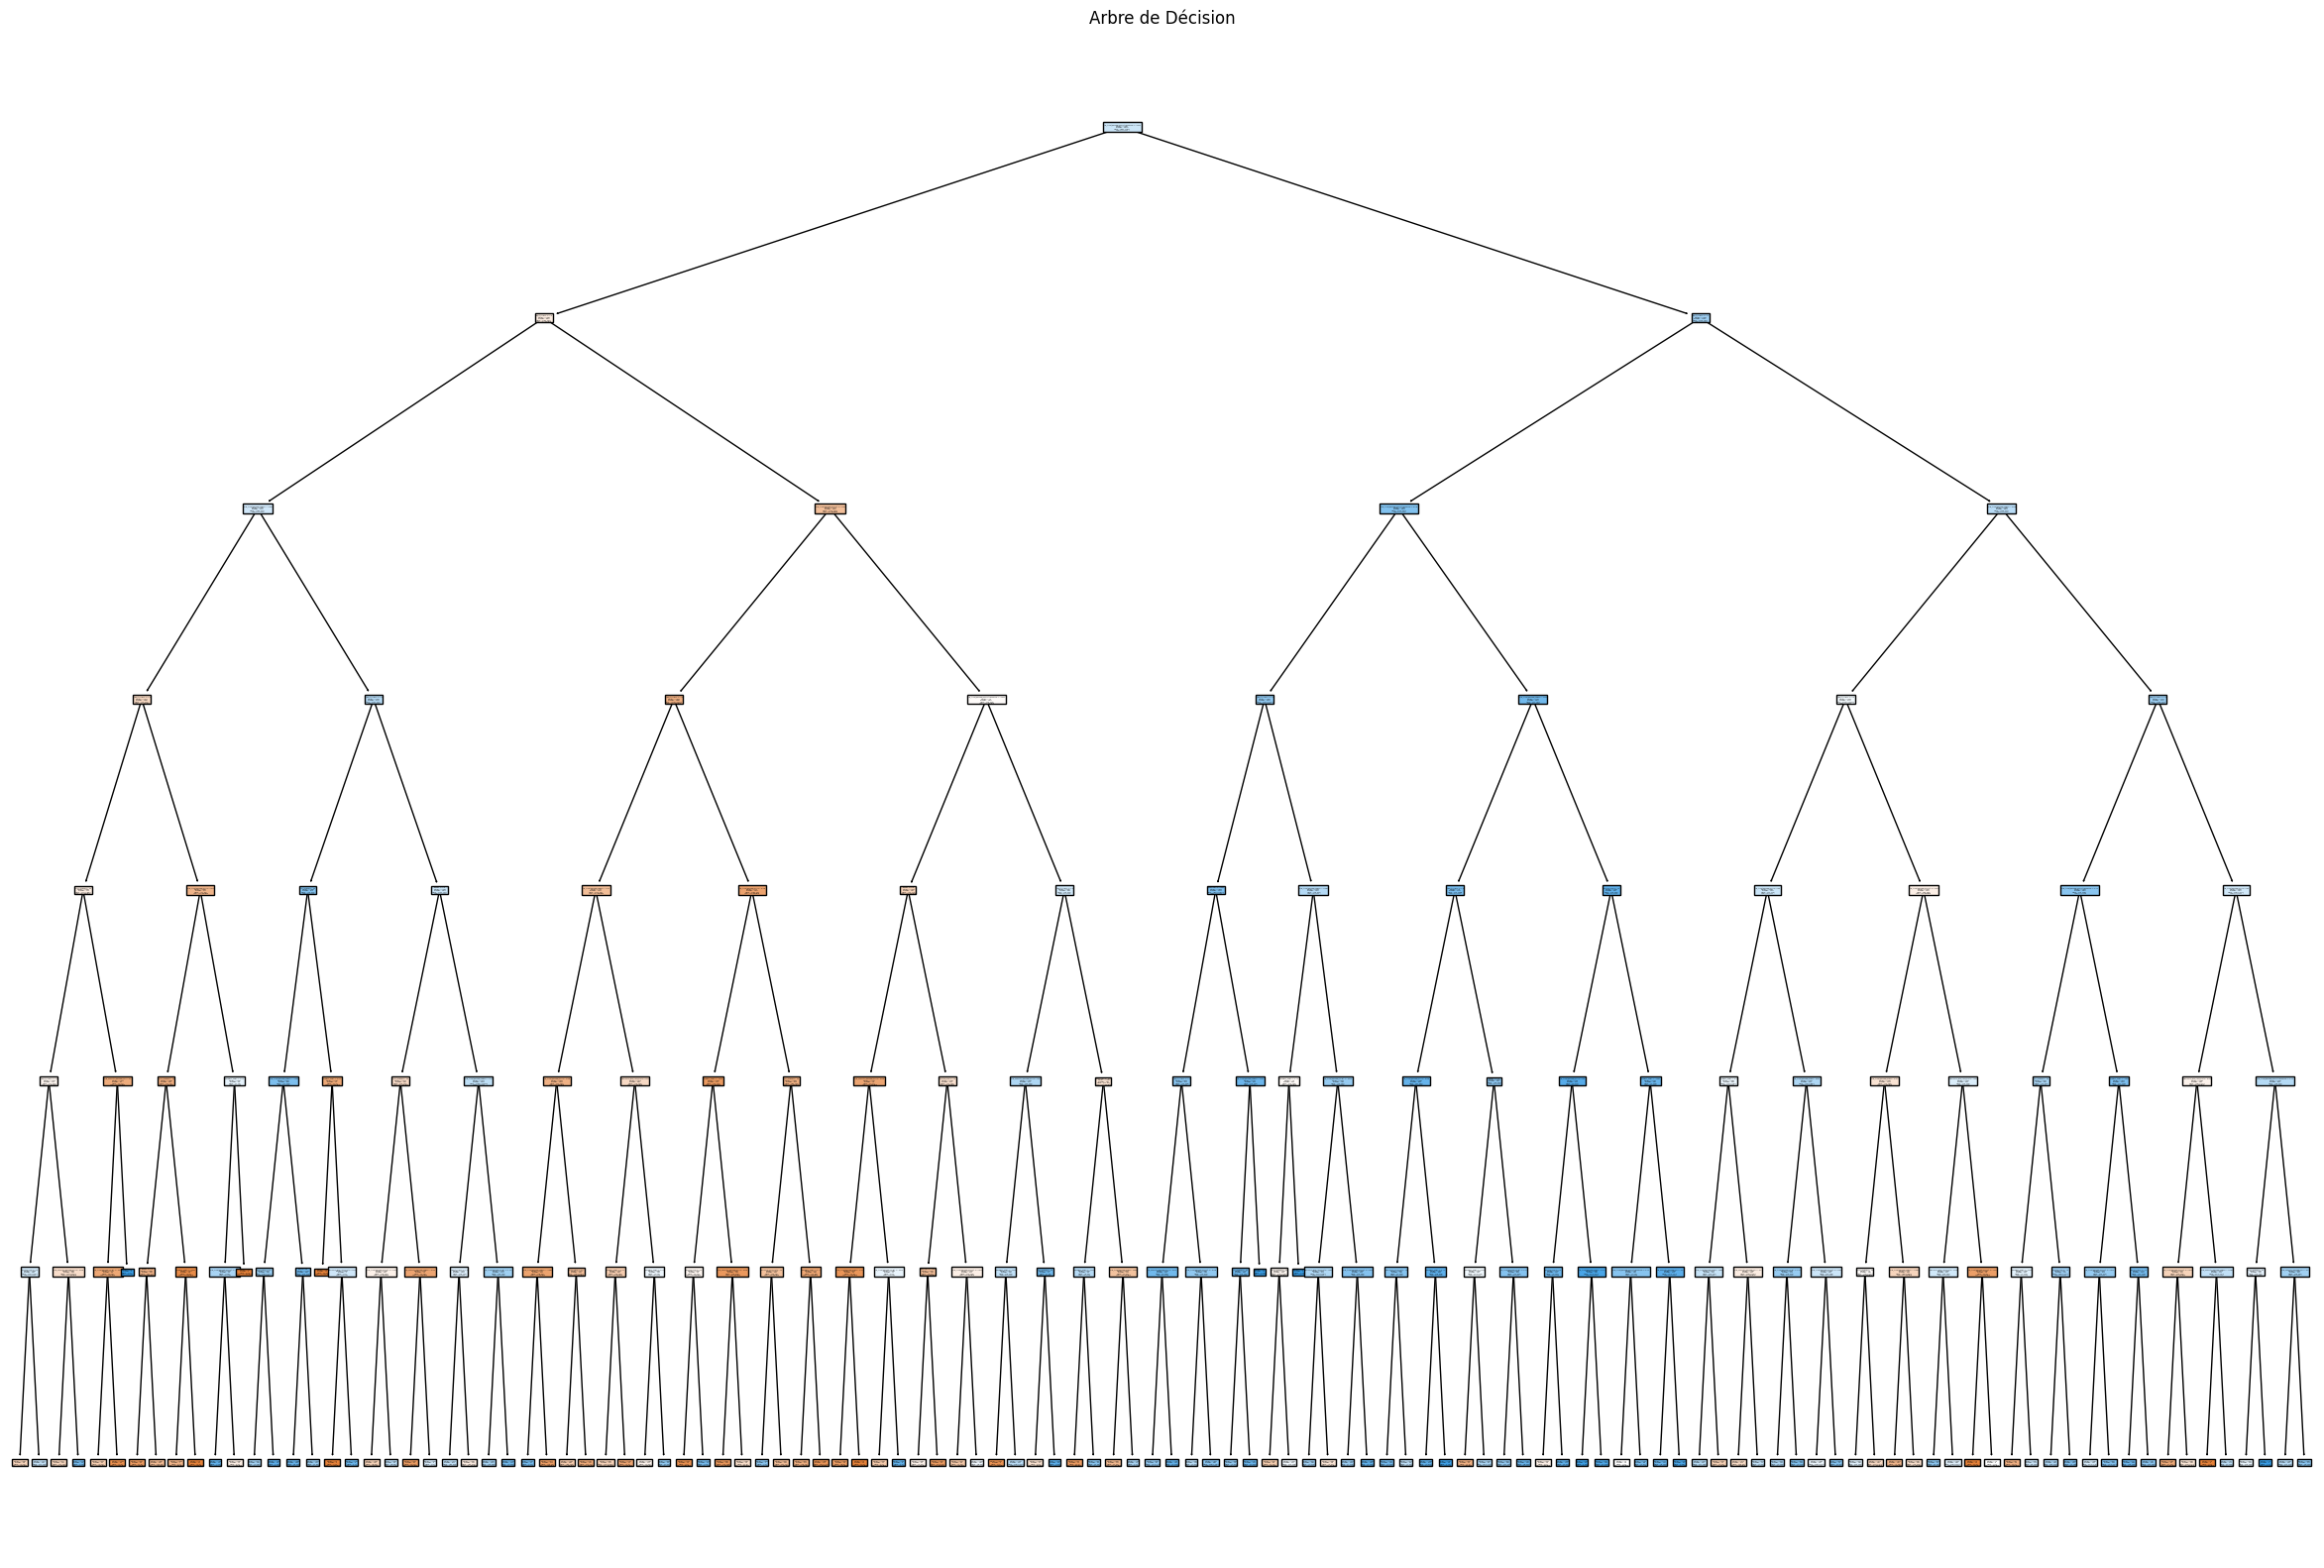

In [35]:
# Tracer l'arbre de décision
plt.figure(figsize=(30, 20))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=['Non-Recidive', 'Recidive'])
plt.title('Arbre de Décision')

plt.savefig('decision_tree.png', format='png', bbox_inches='tight')
plt.show()

# !Random Forest

# 1-Objectif

Random Forest au encore la Forest d'Arbres Decisionnels est une methode qui combine plusieurs arbres de decision pour ameliorer les performances .Elle permet aussi de reduire le surapprentissage en agregeant les predictions de multiples arbres de decision 

Pour notre etude , cette methode est utilisee pour repondre au questions suivantes :

    1-Quelles caracteristiques influenceent le plus la probabilite de recidive dans les trois ans suivant la liberation ?
    2-Comment la performance du modele change-t-elle lorsque nous utilisons diffetents sous-ensemble de caracteristiques pour la prediction ?(par exemple, en utilisant uniquement les variables demogrdemographique ...) 

# 2-Application

In [36]:
# Definition de la target et des features 
target = 'Recidivism_Within_3years'
y = new_df[target]
X = new_df.drop(columns=[target])

In [37]:
#Split du data pour le training et pour le test 
#80% pour le training et 20% pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
# Instantiation du modele
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [39]:
#La cross-validation
#Dans cette etape , la partie de la dataset reservee au training est divisee
#en 5 subsets , ou 4 sont utilisee pour le training et le dernier pour la validation
#ce processus est repete 5 fois .
#En utilisnat cette methode , on peut detecter si il y a un oer fitting et cela va nous donner
#une idee sur la performance du modele face a des donnees qu'il a jamais vu
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
print(f'Cross-Validation AUC Scores: {cv_scores}')
print(f'Mean AUC Score: {cv_scores.mean()}')

Cross-Validation AUC Scores: [0.69652411 0.69461613 0.68875683 0.69386356 0.70390109]
Mean AUC Score: 0.695532343641446


-On remarque que les scores AUC des 5  plis sont proches les uns des autres , ce qui indique une performance coherente et constante sur les differents subsets .

-La moyemme de ces scores ( ~0.7) montre que le modele a une capacite raisonnable a differencier entre recidive et pas de recidive 

In [40]:
# Entrainment du modele
rf.fit(X_train, y_train)

#La prediction sur le données du test
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Evaluation du modele
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC AUC Score: {roc_auc_score(y_test, y_prob)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.6783433326882137
ROC AUC Score: 0.7185767530860028
              precision    recall  f1-score   support

           0       0.65      0.51      0.57      2180
           1       0.69      0.80      0.74      2987

    accuracy                           0.68      5167
   macro avg       0.67      0.66      0.66      5167
weighted avg       0.67      0.68      0.67      5167



-Le modele motre une performance acceptable avec une precision qui veut 68% et une score AUC-ROC de 0.7185 .Cela indique que le modele a une bonne capacite a differencier entre les recidivistes et les non-recidivistes .

-On remarque aussi que la classe 1 a  des scores plus elevee que la classe 0 , ce qui peut indiquer un desequilibre dans les données.

# 2.1-Classement en terme d importance des variables

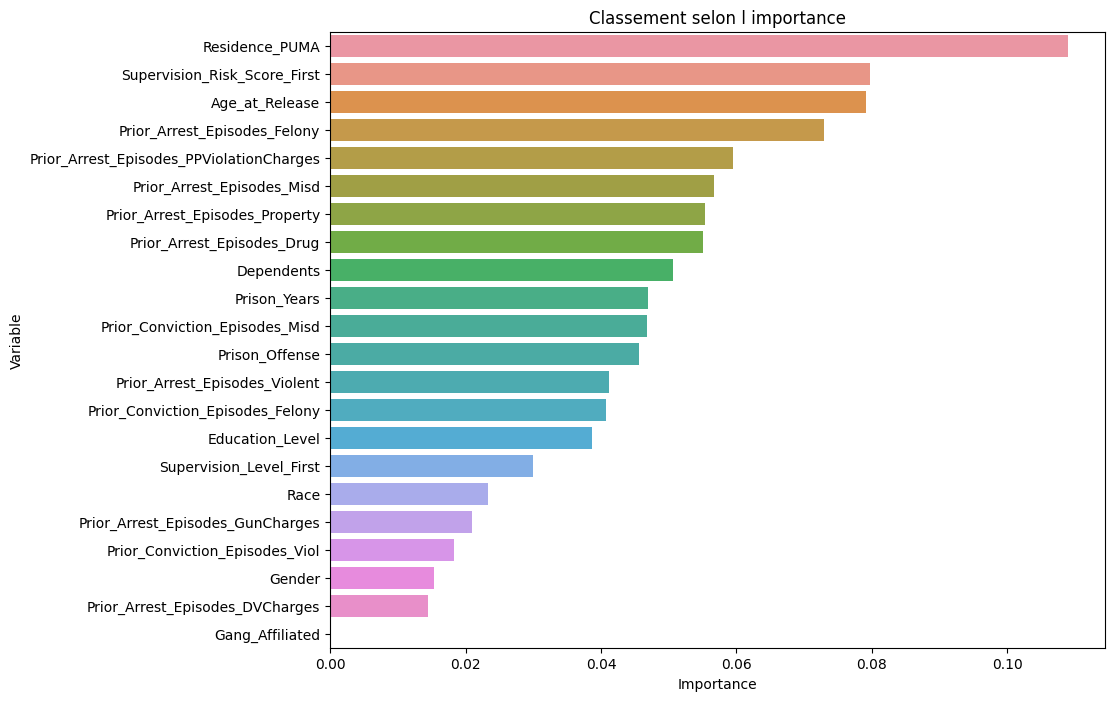

In [41]:
#On extrait les 'importances' des caracteristiques du modele entraine . Chaque importance donne une indication
#sur l'influence de la caracteristique correspondente sur la prediction du modele
feature_importances = rf.feature_importances_

#Creation d'une DataFrame pour la visualisation
feature_importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': feature_importances
})

#Tri par importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Variable', data=feature_importance_df)
plt.title('Classement selon l importance')
plt.show()

D'apres ce graphe , on remarque que : 
   - Residence_PUMA est la caracteristique la plus influente et donc on peut dire que la localisation geographique des individus est un facteur determinat .On peut dire la meme chose sur Supervision_Risk_Score_First ( evaluation initiale du risque ) et Age_at_Release sont également  tres important ainsi que le type de delit pour lequel la personne a ete emprisonnee .
   - Par contre , la race et le sexe ont une influence faible sur la prediction et on a aussi Gang_Affiliated qui est le facteur le moins influent .

# 2.2-Performance selon differents sous-ensembles

In [42]:
#Definition des sous-ensembles : on a essayer de les cier en se basnat sur la relation entre les caracteristiques
sous_ensembles  = {
    'Demographique': ['Gender', 'Race', 'Age_at_Release', 'Residence_PUMA', 'Education_Level'],
    'Supervision_Risk': ['Supervision_Risk_Score_First', 'Supervision_Level_First'],
    'Criminal_History': [
        'Gang_Affiliated', 'Prison_Offense', 'Prison_Years', 'Prior_Arrest_Episodes_Felony', 
        'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property', 
        'Prior_Arrest_Episodes_Drug', 'Prior_Arrest_Episodes_PPViolationCharges', 'Prior_Arrest_Episodes_DVCharges', 
        'Prior_Arrest_Episodes_GunCharges', 'Prior_Conviction_Episodes_Felony'
    ],
    'top_variables' : feature_importance_df['Variable'].iloc[:5].tolist(),
    'top_10_features' : feature_importance_df['Variable'].iloc[:10].tolist() 
}



#Cette fonction permet d'evaluer la performence du modele face aux differents sous ensemble 
def evaluer(variables):
    X_sous = X[variables]
    X_train, X_test, y_train, y_test = train_test_split(X_sous, y, test_size=0.2, random_state=42)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    
    auc_score = roc_auc_score(y_test, y_prob)
    return auc_score

for subset_name, features in sous_ensembles.items():
    auc = evaluer(features)
    print(f'Sous ensemble {subset_name}: AUC Score = {auc}')

Sous ensemble Demographique: AUC Score = 0.5838822205090561
Sous ensemble Supervision_Risk: AUC Score = 0.6188459624734707
Sous ensemble Criminal_History: AUC Score = 0.5993057837786371
Sous ensemble top_variables: AUC Score = 0.6450861224326823
Sous ensemble top_10_features: AUC Score = 0.6884146285279023


-Les caracteristiques demographiques telles montre une influence limitee sur la capacite du modele a predire la recidive  et c'est aussi la plus faible par rapport aux autre sous-ensembles, malgre le fait que Residence_PUMA et Age_at_Release sont identifies comme etant la meilleures caracteristiques .
Ceci peut etre due au fait que ces variables sont correlees avec d'autre variables et donc leur contribution seule n'est pas suffisante .

ET donc on ne peut pas se baser  seulement sur ces caracteristiques pour une prediction efficace . Pariel pour le sous-ensemble Criminal_history.

-L'utilisation des dix caracteristiques les plus importantes selon le modele presente le meilleure score (0.6888) , ce qui indique qu'elles capturent la majorite des informations. Et donc pour une meilleure prediction on peut se concentrer sur celles-ci tout en considerant ces sous-ensembles pour affiner les predictions

# !K-means

# 1-Objectif

On choisi K-means pour notre etude pour repondre aux questions suivantes :

    1-Quels sont les sou-groupes principaux identifies dans la dataset ?
    2-Quelles caracteristiques sont les plus representatives pour chaque cluster ?

# 2-Application

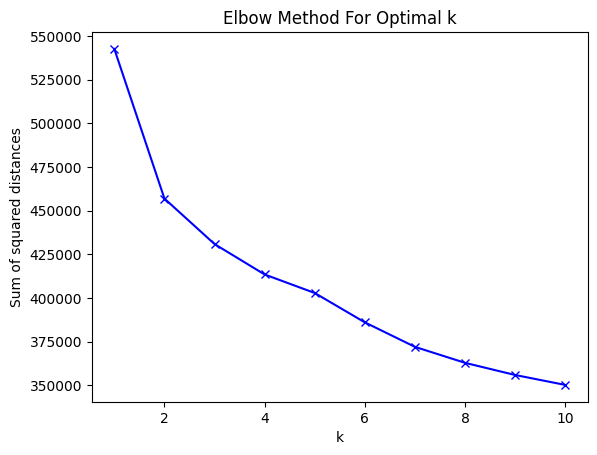

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
variables = new_df.drop('Recidivism_Within_3years', axis=1)
scaled_variables = scaler.fit_transform(variables)
scaled_df = pd.DataFrame(scaled_variables, columns=variables.columns)

#Cherchon d'abord le nombre optimale de clusters

ssd = []
K = range(1, 11) 
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_df)
    ssd.append(km.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

D apres le graphe , le nombre optimale est 2  , car c'est le point represantant le coude .C'est le nombre de clusters à partir duquel la variance ne se réduit plus significativement 

In [44]:
# Nombre de clusters
nb_groupes = 2

# Appliquer K-means
kmeans = KMeans(n_clusters=nb_groupes, random_state=0).fit(scaled_df)

# Affichage des centres des clusters
print("Centres des clusters :")
print(kmeans.cluster_centers_)

Centres des clusters :
[[ 0.05222171  0.04743655  0.40184506  0.04371979  0.         -0.06255197
   0.10197658  0.09757993  0.09761789 -0.15394936 -0.16169554  0.78255937
   0.75140921  0.36809902  0.52995936  0.42292106  0.71232557  0.28055344
   0.10702401  0.64820976  0.71573138  0.2370283 ]
 [-0.04793775 -0.04354513 -0.36888004 -0.04013328  0.          0.05742057
  -0.09361102 -0.08957504 -0.08960989  0.14132025  0.14843098 -0.71836278
  -0.689768   -0.33790233 -0.48648459 -0.38822709 -0.65389054 -0.25753847
  -0.09824438 -0.59503442 -0.65701697 -0.21758389]]


-Le cluster 0 a des valeurs moyennes positives pour la plupart des caracteristiques , cela est une indication que les individus de ce cluster en generalement des valeurs elevees pour ces caracteristiques .

-Par contre pour le cluster 1 , la plupart des valeurs sont negatives , et donc les individus on generalement des valeurs faibles pour les caracteristiques

-On peut aussi constater que des caracteristiques comme Prison_Years , Prior_Arrest_Episodes_Feloney et Age_At_Release (ayant des valeurs positives dans un cluster et negatives dans l autre )  jouent un role cle dans la differenciation .

In [45]:
# Calculer l'exactitude du clustering
labels = kmeans.labels_
correct_labels = sum(recidivism == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
# Calculer le pourcentage de labels corrects
accuracy = correct_labels / y.size * 100
print(f"Accuracy: {accuracy:.2f}%")

Result: 11061 out of 25835 samples were correctly labeled.
Accuracy: 42.81%


Pour 42.81% des échantillons, le label de cluster assigné par K-Means correspond à la valeur réelle de récidive. En d'autres termes, dans 43.01% des cas, le modèle de clustering a correctement identifié si un individu récidivera ou non dans les 3 ans suivant sa libération.

Le taux de precision faible peut indiquer une grande variabilite dans les données.

# Conclusion : comparaison globale

->Au niveau de la precision , Random Forest a la valeur la plus elevee (67.84%) , suivi par la regression logistique puis Decision Tree . K-means a la valeur la plus faible .

->La regression logistique a la meilleure precision pour la classe 1 (0.69) , suivi par Random Forest et Decision Tree .

->Random forest a une valeur de precision un peu plus elevee par rapport aux autres modeles .

->Les scores faibles de K-means indiquent que ce medele n'est pas le plus performant dans ce contexte .

->De maniere generale , Random Forest est le modele le plus performant dans cette analyse . 